## Basic import and stuff from Notebook-08

In [17]:
from dotenv import load_dotenv
import os

load_dotenv('../.env_api')

os.environ["HTTP_PROXY"] = "http://localhost:9090"
os.environ["HTTPS_PROXY"] = "http://localhost:9090"
# os.environ["NO_PROXY"] = os.getenv("NO_PROXY", "localhost,127.0.0.1,qdrant,::1")
os.environ["REQUESTS_CA_BUNDLE"] = "/Users/tomek/Library/Application Support/com.proxyman.NSProxy-setapp/app-data/proxyman-ca.pem"
os.environ["SSL_CERT_FILE"] = "/Users/tomek/Library/Application Support/com.proxyman.NSProxy-setapp/app-data/proxyman-ca.pem"

from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import Literal, Dict, Any, Annotated, List, Optional
from operator import add
import random
import ast
import inspect
from langgraph.prebuilt import ToolNode
from jinja2 import Template
import instructor
from openai import OpenAI
from langchain_core.messages import AIMessage, ToolMessage
import json

from qdrant_client import QdrantClient
# from src.api.core.config import config
from langsmith import traceable, get_current_run_tree
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery
import openai
import logging

from rich.pretty import pprint

logger_id = 0
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]

for logger in loggers:
    logger.handlers.clear()
    logger.propagate = False
    logger.disabled = True

logger_id += 1
logger = logging.getLogger('Notebook ' + str(logger_id))
logger.propagate = True
logger.setLevel(logging.INFO)
stream_handler = logging.StreamHandler()
formatter = logging.Formatter(f"\033[94m%(asctime)s %(levelname)s %(name)s %(message)s\033[0m")
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logger.propagate = False
logger.info("Retrieval logger initialized")
qdrant_client = QdrantClient(
    url=f'http://localhost.proxyman.io:6333'
)

@traceable(
    name="embed_query_text",
    run_type="embedding",
    metadata={"ls_provider": 'openai', "ls_model_name": 'text-embedding-3-small'}
)
def get_embedding_openai(text, model='text-embedding-3-small'):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )

    current_run = get_current_run_tree()
    if current_run:
        current_run.metadata['usage_metadata'] = {
            'input_tokens': response.usage.prompt_tokens,
            'total_tokens': response.usage.total_tokens,
        }
    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type="retriever",
)
def retrieve_context(query, embedding_type = 'text', fusion = True, top_k=5):
    embedding_function = get_embedding_openai 
    if embedding_type == 'image':
        embedding_function = get_embedding_openclip
    query_embedding = embedding_function(query)
    collection_name = 'Amazon-items-collection-01-hybrid'
    if fusion:
        logger.info("Fusion enabled. Retrieving for query: {} top {} results from {} collection".format(query, top_k, collection_name))
        results = qdrant_client.query_points(
            collection_name=collection_name,
            prefetch=[
                Prefetch(
                    query=query_embedding,
                    limit=20,
                ),
                Prefetch(
                    filter=Filter(
                        must=[
                            FieldCondition(
                                key="text",
                                match=MatchText(
                                    text=query,
                                )
                            )
                        ]
                    ),
                    limit=20
                )
            ],
            query=FusionQuery(fusion="rrf"),
            limit=top_k,
        )
    else:
        logger.info("Fusion disabled. Retrieving top {} results from {} collection".format(top_k, collection_name))
        results = qdrant_client.query_points(
            collection_name=collection_name,
            query=query_embedding,
            limit=top_k,
        )
    logger.info(f"Retrieved {len(results.points)} results")
    current_run = get_current_run_tree()
    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []
    for result in results.points:
        retrieved_context_ids.append(result.id)
        retrieved_context.append(result.payload['text'])
        similarity_scores.append(result.score)

    return {
        "retrieved_context_ids": retrieved_context_ids,
        "retrieved_context": retrieved_context,
        "similarity_scores": similarity_scores,
    }

@traceable(
    name="format_retrieved_context",
    run_type="prompt",
)
def process_context(context):
    formatted_context = ""
    for index, chunk in zip(context['retrieved_context_ids'], context['retrieved_context']):
        formatted_context += f"- {index}: {chunk} \n"

    return formatted_context

def get_formatted_context(query: str, top_k: int = 5) -> str:
    """Get the top k context, each representing an inventory item for a given query.
    
    Args:
        query: The query to get the top k context for
        top_k: The number of context chunks to retrieve, works best with 5 or more
    
    Returns:
        A string of the top k context chunks with IDs prepending each chunk, each representing an inventory item for a given query.
    """

    logger.info(f"Getting formatted context for query: {query}")
    context = retrieve_context(query, top_k=top_k)
    formatted_context = process_context(context)
    return formatted_context


In [85]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class RAGUsedContext(BaseModel):
    id: int
    description: str

class AgentResponse(BaseModel): # structured output for pydantic
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)
    final_answer: bool = Field(default=False)
    retrieved_context: List[RAGUsedContext]

class CritiqueResponse(BaseModel):
    """
    Pydantic model for the critique response generated by the LLM.

    Fields:
        critique: A string containing the critique or feedback on the agent's answer.
        suggested_improvements: A list of strings, each representing a suggested improvement to the answer or process.

    Example (for LLM prompt):
        {
            "critique": "The answer did not consider all user requirements.",
            "suggested_improvements": [
                "Include more product options for kids.",
                "Clarify the price range for each item."
            ]
        }
    """
    critique: str
    suggested_improvements: List[str]

class RefinementResponse(BaseModel):
    """
    Pydantic model for the refinement response generated by the LLM.

    Fields:
        refinement: A string containing the refinement or feedback on the agent's answer.
    """
    refined_answer: str

class State(BaseModel):
    messages: Annotated[List[Any], add] = [] # reducer (it will add messages to the list)
    iteration: int = Field(default=0)
    answer: str = ""
    final_answer: bool = Field(default=False)
    available_tools: List[Dict[str, Any]] = []
    tool_calls: Optional[List[ToolCall]] = Field(default_factory=list)
    retrieved_context: Annotated[List[RAGUsedContext], add] = []
    critique_loops: int = Field(default=0)
    critique: Annotated[List[str], add] = Field(default_factory=list)
    suggested_improvements: Annotated[List[List[str]], add] = Field(default_factory=list)


### Agent Node

In [86]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": 'openai', "ls_model_name": 'gpt-4.1-mini'}
)
def agent_node(state: State) -> dict:
   prompt_template =  """    
You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of tools you can use to answer that question.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

After the tools are used you will get the outputs from the tools.

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Use names specificly provided in the available tools. Don't add any additional text to the names.

You should tend to use tools when additional information is needed to answer the question.

If you set final_answer to True, you should not use any tools.

Instructions:
- You need to answer the question based on the retrieved context using the available tools only.
- Never use word context and refer to it as the available products.
- You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.
- As a final output you need to provide:

* The answer to the question based on the retrieved context.
* The list of the indexes from the chunks returned from all tool calls that were used to answer the question. If more than one chunk was used to compile the answer from a single tool call, be sure to return all of them.
* Short description of the item based on the retrieved context.

- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.
- The short description should have the name of the item.
- If the user's request requires using a tool, set tool_calls with the appropriate function name and arguments.
- If you have all the information needed to provide a complete answer, set final_answer to True.
""" 

   template = Template(prompt_template)

   prompt = template.render(
      available_tools=state.available_tools
   )

   messages = state.messages

   conversation = []
   for message in messages:
      conversation.append(lc_messages_to_regular_messages(message))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
      model="gpt-4.1-mini",
      response_model=AgentResponse,
      messages=[{"role": "system", "content": prompt}, *conversation],
      temperature=0.5,
   )

   if response.tool_calls:
      tool_calls = []
      for i, tc in enumerate(response.tool_calls):
         tool_calls.append({
               "id": f"call_{i}",
               "name": tc.name,
               "args": tc.arguments
         })

      ai_message = AIMessage(
         content=response.answer,
         tool_calls=tool_calls
      )
   else:
      ai_message = AIMessage(
         content=response.answer,
      )

   return {
      "messages": [ai_message],
      "tool_calls": response.tool_calls,
      "iteration": state.iteration + 1,
      "answer": response.answer,
      "final_answer": response.final_answer,
      "retrieved_context": response.retrieved_context,
   }

In [87]:
def tool_router(state: State) -> str:
    """Decide whether to continue or end"""

    if state.final_answer:
        return 'end'
    elif state.iteration > 3:
        return 'end'
    elif len(state.tool_calls) > 0:
        return 'tools'
    else:
        return 'end'

## Critique Node

In [94]:
@traceable(
    name="critique_node",
    run_type="llm",
    metadata={"ls_provider": 'openai', "ls_model_name": 'gpt-4.1-mini'}
)
def critique_node(state: State) -> dict:
    """Critique the agent's response"""
    prompt_template = """
    You are here to critique the agent's response. 
    And suggest improvements.
    <Conversation history>
    {{ history | tojson }}
    </Conversation history>

    <Available tools>
    {{ state.available_tools | tojson }}
    </Available tools>

    <Agent response>
    {{ state.answer }}
    </Agent response>

    Please respond with a critique and a list of suggested improvements according to schema.
    If you believe that the agent's response is already good, you can return an empty list for suggested improvements.
    Ignore the tone and politeness.

    """

    template = Template(prompt_template)

    prompt = template.render(
        state=state,
        history=[lc_messages_to_regular_messages(message) for message in state.messages]
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=CritiqueResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
    )

    critique = response.critique
    suggested_improvements = response.suggested_improvements    

    return {
        "critique": [critique],
        "suggested_improvements": [suggested_improvements],
        "critique_loops": state.critique_loops + 1,
        'messages': [AIMessage(content=critique)]
    }
   

### Refinement node

In [95]:
@traceable(
    name="refinement_node",
    run_type="llm",
    metadata={"ls_provider": 'openai', "ls_model_name": 'gpt-4.1-mini'}
)
def refinement_node(state: State) -> dict:
    """Refine the agent's response"""

    prompt_template = """
    You are here to refine the agent's response.

    <Conversation history>
    {{ history | tojson }}
    </Conversation history>

    <Agent response>
    {{ state.answer }}
    </Agent response>

    <Critique>
    {{ critique }}
    </Critique>

    <Suggested improvements>
    {{ suggested_improvements | join('\n- ') }}
    </Suggested improvements>

    """

    template = Template(prompt_template)

    prompt = template.render(
        state=state,
        history=[lc_messages_to_regular_messages(message) for message in state.messages]
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=RefinementResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
    )

    return {
        'answer': response.refined_answer,
        'messages': [AIMessage(content=response.refined_answer)]
    }

   

## Graph

In [98]:
def refinement_router(state: State) -> str:
    if state.critique_loops < 3 and state.suggested_improvements[-1]:
        return 'refine'
    else:
        return 'end'

workflow = StateGraph(State)

tools = [get_formatted_context]

tool_node = ToolNode(tools)

tool_descriptions = get_tool_descriptions_from_node(tool_node)

workflow.add_node('agent_node', agent_node)
workflow.add_node('tool_node', tool_node)
workflow.add_node('critique_node', critique_node)
workflow.add_node('refinement_node', refinement_node)

workflow.add_edge(START, "agent_node")
workflow.add_conditional_edges(
    'agent_node',
    tool_router,
    {
        'tools': 'tool_node',
        'end': 'critique_node'
    }
)
workflow.add_edge('tool_node', 'agent_node')
workflow.add_conditional_edges(
    'critique_node',
    refinement_router,
    {
        'refine': 'refinement_node',
        'end': END
    }
)
workflow.add_edge('refinement_node', 'critique_node')

graph = workflow.compile()

initial_state = {
    # "messages": [{"role": "user", "content": "What is the time?"}],
    "messages": [{"role": "user", "content": "Can i get earphones for myself, a laptop bag for my wife and something cool for my kids?"}],
    "available_tools": tool_descriptions,
}

for mode, chunk in graph.stream(initial_state, stream_mode=["values", "updates"]):   
    if mode == "updates":
        pprint(chunk)
    if mode == "values":
        result = chunk
pprint('### RESULT ###')
pprint(result)


{
│   'agent_node': {
│   │   'messages': [
│   │   │   AIMessage(
│   │   │   │   content='I will look for earphones, a laptop bag, and something cool for kids in the available products.',
│   │   │   │   additional_kwargs={},
│   │   │   │   response_metadata={},
│   │   │   │   tool_calls=[
│   │   │   │   │   {
│   │   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   │   'args': {'query': 'earphones', 'top_k': 3},
│   │   │   │   │   │   'id': 'call_0',
│   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   },
│   │   │   │   │   {
│   │   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   │   'args': {'query': 'laptop bag', 'top_k': 3},
│   │   │   │   │   │   'id': 'call_1',
│   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   },
│   │   │   │   │   {
│   │   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   │   'args': {'query': 'kids', 'top_k': 3},
│   │   │   │   │   │   'id': 'call_2',
│   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   }
│   │   │   │   ]
│   │   │   )
│   │   ],
│   │   'tool_calls': [
│   │   │   ToolCall(name='get_formatted_context', arguments={'query': 'earphones', 'top_k': 3}),
│   │   │   ToolCall(name='get_formatted_context', arguments={'query': 'laptop bag', 'top_k': 3}),
│   │   │   ToolCall(name='get_formatted_context', arguments={'query': 'kids', 'top_k': 3})
│   │   ],
│   │   'iteration': 1,
│   │   'answer': 'I will look for earphones, a laptop bag, and something cool for kids in the available products.',
│   │   'final_answer': False,
│   │   'retrieved_context': []
│   }
}

{
│   'tool_node': {
│   │   'messages': [
│   │   │   ToolMessage(
│   │   │   │   content='- 11: IKG Wireless Earbuds, Bluetooth Headphones with Microphone, 30H Playtime with Transparent Charging Case, Deep Bass, IPX7 Waterproof, Earphones for Work Sport Game Ergonomic design and unique appearance: the weight of a single earbud is only 3.5g, round and smooth sound cavity design, 35 ° of the golden angle of entry into the ear, the curve of the body design of the fit to provide a good airtightness. Headphones wireless unique transparent cover and simple charging compartment design, easily adapt to different scenarios. Bluetooth 5.3 and automatic one-step connection: The in-ear headphones provide simultaneous binaural transmission through the use of Bluetooth 5.3 chip, increasing the connection speed by 80%. Dual-channel transmission technology for seamless switching between single/binaural modes. By opening the lid of the charging case, the Bluetooth headset can automatically connect to the previously paired device. Subwoofer and CVC8.0: The headset speaker uses a 13.4mm composite diaphragm with a large dynamic coil to create a spatial 3D panoramic sound effect, earbuds wirelessly improve sound quality by 90%, and support for audio HD decoding and CVC8.0 lets you enjoy clear calls. Equipped with an optical infrared sensor to support in-ear recognition. Touch operation, IPX7 waterproof: Wireless headphones can easily control volume, songs, calls and voice assistants with a simple touch of a finger on the side of the headphone shaft, and the controls can be used completely off the phone. IPX7 waterproof earbuds, rain and sweat resistant, BTW86 wireless earbuds are a great helper when playing sports. Type-C fast charging, 30 hours of life: The wireless headphone charging case is equipped with a Type-C charging port, which increases the charging speed by 2 times and can be easily charged in 10 minutes and used for 1 hour. The headphones and charging case can last up to 30 hours. \n- 1: Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass in-Ear Earphones Premium Sound with Mic Wireless Charging Case for iPhone, Samsung, Android Smartphone Laptop Sports [Advanced Bluetooth Technology] Our earbuds adopt Bluetooth 5.3 technology, which greatly improves the transmission speed and provides a low-latency listening experience. With support for A2DP, AVRCP, HFP, and more, you can enjoy seamless connectivity and superb audio quality. [Enhanced Audio Experience] Immerse yourself in powerful, deep bass with our wireless earbuds. Designed to provide extra punch, warmth, and impact to keep you energized during your workout and deliver crystal-clear sound for a superior listening experience. [Long Battery Life] Enjoy up to 5 hours of playback time per earbud, and a total of over 22 hours (100% volume) when combined with the charging case. Enjoy a full day of listening enjoyment with just 1.5 hours of charging time. Charge easily with the included charging case and Type-C charging cable. [Comfortable and Secure Fit] Designed with a slim profile and a longer earbud stem, our wireless earbuds offer a more snug in-ear fit. This creates a perfect seal, improves sound quality, and ensures a comfortable and secure fit, making them ideal for active lifestyles and sports activities. [Convenient Touch Control] Our wireless earbuds have a smart touch control function, you can easily play/pause music, skip songs, activate voice assistant, and answer calls with just a tap of the earbuds. With the built-in microphone, you can experience clear calls even in noisy environments, and easily activate Siri or Google Assistant. \n- 24: Wireless Earbuds Bluetooth Headphones 130Hrs Playtime with 2500mAh Wireless Charging Case LED Diaplay Hi-Fi Waterproof Over Ear Earphones for Sports Running Workout Gaming Wireless Charging Case with LED Display: 2500mAh charging case supports 16 times fully charging for wireless earbuds and let you enjoy more than 130 hours music tim

{
│   'agent_node': {
│   │   'messages': [
│   │   │   AIMessage(
│   │   │   │   content='Here are the options for your requests:\n\n1. Earphones:\n- IKG Wireless Earbuds Bluetooth Headphones with Microphone\n- Features:\n  - 30 hours playtime with transparent charging case\n  - Deep bass and IPX7 waterproof\n  - Ergonomic design with unique appearance\n  - Bluetooth 5.3 with automatic one-step connection\n  - Subwoofer and CVC8.0 for clear calls\n  - Touch operation\n  - Type-C fast charging\n\n2. Laptop Bag:\n- MOSISO Laptop Sleeve Compatible with MacBook Air/Pro 13-13.3 inch\n- Features:\n  - Made with garden flowers polyester material\n  - Slim and lightweight with extra front pocket\n  - Polyester foam padding and fluffy fleece fabric lining for protection\n  - Compatible with various laptop models\n\n3. Something cool for kids:\n- VuyKoo Cat Ear Bluetooth Headphones with Microphone/LED Light Up\n- Features:\n  - Volume limiting to protect hearing\n  - Memory protein ear pads for comfort\n  - Foldable and adjustable headband\n  - Bluetooth 5.0 connection with built-in HD microphone\n  - Comes with USB charging cable, audio cable, and gift box packaging\n\nIf you want more options or details about any of these, please let me know!',
│   │   │   │   additional_kwargs={},
│   │   │   │   response_metadata={},
│   │   │   │   tool_calls=[
│   │   │   │   │   {
│   │   │   │   │   │   'name': 'functions.get_formatted_context',
│   │   │   │   │   │   'args': {'query': 'earphones', 'top_k': 3},
│   │   │   │   │   │   'id': 'call_0',
│   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   },
│   │   │   │   │   {
│   │   │   │   │   │   'name': 'functions.get_formatted_context',
│   │   │   │   │   │   'args': {'query': 'laptop bag', 'top_k': 3},
│   │   │   │   │   │   'id': 'call_1',
│   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   },
│   │   │   │   │   {
│   │   │   │   │   │   'name': 'functions.get_formatted_context',
│   │   │   │   │   │   'args': {'query': 'kids', 'top_k': 3},
│   │   │   │   │   │   'id': 'call_2',
│   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   }
│   │   │   │   ]
│   │   │   )
│   │   ],
│   │   'tool_calls': [
│   │   │   ToolCall(name='functions.get_formatted_context', arguments={'query': 'earphones', 'top_k': 3}),
│   │   │   ToolCall(name='functions.get_formatted_context', arguments={'query': 'laptop bag', 'top_k': 3}),
│   │   │   ToolCall(name='functions.get_formatted_context', arguments={'query': 'kids', 'top_k': 3})
│   │   ],
│   │   'iteration': 2,
│   │   'answer': 'Here are the options for your requests:\n\n1. Earphones:\n- IKG Wireless Earbuds Bluetooth Headphones with Microphone\n- Features:\n  - 30 hours playtime with transparent charging case\n  - Deep bass and IPX7 waterproof\n  - Ergonomic design with unique appearance\n  - Bluetooth 5.3 with automatic one-step connection\n  - Subwoofer and CVC8.0 for clear calls\n  - Touch operation\n  - Type-C fast charging\n\n2. Laptop Bag:\n- MOSISO Laptop Sleeve Compatible with MacBook Air/Pro 13-13.3 inch\n- Features:\n  - Made with garden flowers polyester material\n  - Slim and lightweight with extra front pocket\n  - Polyester foam padding and fluffy fleece fabric lining for protection\n  - Compatible with various laptop models\n\n3. Something cool for kids:\n- VuyKoo Cat Ear Bluetooth Headphones with Microphone/LED Light Up\n- Features:\n  - Volume limiting to protect hearing\n  - Memory protein ear pads for comfort\n  - Foldable and adjustable headband\n  - Bluetooth 5.0 connection with built-in HD microphone\n  - Comes with USB charging cable, audio cable, and gift box packaging\n\nIf you want more options or details about any of these, please let me know!',
│   │   'final_answer': True,
│   │   'retrieved_context': [
│   │   │   RAGUsedContext(
│   │   │   │   id=11,
│   │   │   │   description='IKG Wireless Earbuds, Bluetooth Headphones with Microphone, 30H Playtime with Transparent Charging Ca

{
│   'critique_node': {
│   │   'critique': [
│   │   │   'The assistant\'s response is clear, well-structured, and provides detailed descriptions of one product option for each of the user\'s requests: earphones, a laptop bag, and a cool item for kids. The product features are concisely summarized, which helps the user understand the benefits of each item. Additionally, the assistant invites the user to ask for more options or details, which is good for user engagement.\n\nHowever, the assistant only presented one option per category despite retrieving multiple items from the tool calls. The user might benefit from seeing more than one option per category to make a better-informed decision. Also, the assistant could improve by including prices or price ranges if available, or at least mentioning availability or stock status. Finally, the phrase "something cool for kids" is vague; the assistant could clarify that the suggested item is a kids\' product with fun or unique features, which it partially does but could emphasize more.'
│   │   ],
│   │   'suggested_improvements': [
│   │   │   [
│   │   │   │   'Present multiple product options per category instead of just one to provide variety.',
│   │   │   │   "Include price information or mention availability if possible to aid the user's decision.",
│   │   │   │   'Enhance the description of the kids\' item to emphasize why it is "cool" or suitable for kids.',
│   │   │   │   'Consider adding a brief summary or comparison to help the user choose among the options.',
│   │   │   │   'Mention return policies, warranties, or other relevant purchase information if available.'
│   │   │   ]
│   │   ],
│   │   'critique_loops': 1,
│   │   'messages': [
│   │   │   AIMessage(
│   │   │   │   content='The assistant\'s response is clear, well-structured, and provides detailed descriptions of one product option for each of the user\'s requests: earphones, a laptop bag, and a cool item for kids. The product features are concisely summarized, which helps the user understand the benefits of each item. Additionally, the assistant invites the user to ask for more options or details, which is good for user engagement.\n\nHowever, the assistant only presented one option per category despite retrieving multiple items from the tool calls. The user might benefit from seeing more than one option per category to make a better-informed decision. Also, the assistant could improve by including prices or price ranges if available, or at least mentioning availability or stock status. Finally, the phrase "something cool for kids" is vague; the assistant could clarify that the suggested item is a kids\' product with fun or unique features, which it partially does but could emphasize more.',
│   │   │   │   additional_kwargs={},
│   │   │   │   response_metadata={}
│   │   │   )
│   │   ]
│   }
}

{
│   'refinement_node': {
│   │   'answer': "Here are several options for your requests to help you choose the best fit:\n\n1. Earphones:\n- IKG Wireless Earbuds Bluetooth Headphones with Microphone\n  - 30 hours playtime with transparent charging case\n  - Deep bass and IPX7 waterproof\n  - Ergonomic design with unique appearance\n  - Bluetooth 5.3 with automatic one-step connection\n  - Subwoofer and CVC8.0 for clear calls\n  - Touch operation and Type-C fast charging\n\n- Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass In-Ear Earphones\n  - Up to 5 hours playback per earbud, 22+ hours with charging case\n  - Comfortable and secure fit\n  - Advanced Bluetooth technology with touch controls\n  - Clear calls with built-in microphone\n\n- Wireless Earbuds Bluetooth Headphones with 130H Playtime and Wireless Charging Case\n  - 130 hours total playtime with large charging case\n  - Hi-Fi stereo bass and crystal-clear calling\n  - IPX7 waterproof and ergonomic lightweight earhooks\n  - LED display on charging case\n\n2. Laptop Bags:\n- MOSISO Laptop Sleeve Compatible with MacBook Air/Pro 13-13.3 inch\n  - Garden flowers polyester material\n  - Slim, lightweight with extra front pocket\n  - Protective foam padding and fleece lining\n  - Compatible with many laptop models\n\n- DOXONN Laptop Holder Vertical, Aluminum Adjustable Stand\n  - Tool-free adjustable width\n  - Aluminum construction with silicone padding\n  - Supports M2 MacBook Air and most laptops\n  - Helps with heat dissipation and desk organization\n\n- Bracwiser Foldable Monitor Riser Metal Computer Stand\n  - Adjustable height with pen storage\n  - Supports laptops and monitors up to 44 lbs\n  - Ergonomic design to improve posture\n\n3. Something Cool for Kids:\n- VuyKoo Cat Ear Bluetooth Headphones with Microphone/LED Light Up\n  - Volume limiting to protect hearing\n  - Comfortable memory protein ear pads\n  - Foldable and adjustable headband\n  - Bluetooth 5.0 connection with built-in microphone\n  - Includes charging and audio cables, gift box packaging\n\n- 200PCS Anime Stickers Mixed Pack\n  - Trendy manga stickers for decorating laptops, water bottles, and more\n  - Waterproof, sun-proof, and removable without residue\n  - Great for personalizing kids' belongings\n\nIf you want more details or pricing information on any of these options, please let me know!",
│   │   'messages': [
│   │   │   AIMessage(
│   │   │   │   content="Here are several options for your requests to help you choose the best fit:\n\n1. Earphones:\n- IKG Wireless Earbuds Bluetooth Headphones with Microphone\n  - 30 hours playtime with transparent charging case\n  - Deep bass and IPX7 waterproof\n  - Ergonomic design with unique appearance\n  - Bluetooth 5.3 with automatic one-step connection\n  - Subwoofer and CVC8.0 for clear calls\n  - Touch operation and Type-C fast charging\n\n- Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass In-Ear Earphones\n  - Up to 5 hours playback per earbud, 22+ hours with charging case\n  - Comfortable and secure fit\n  - Advanced Bluetooth technology with touch controls\n  - Clear calls with built-in microphone\n\n- Wireless Earbuds Bluetooth Headphones with 130H Playtime and Wireless Charging Case\n  - 130 hours total playtime with large charging case\n  - Hi-Fi stereo bass and crystal-clear calling\n  - IPX7 waterproof and ergonomic lightweight earhooks\n  - LED display on charging case\n\n2. Laptop Bags:\n- MOSISO Laptop Sleeve Compatible with MacBook Air/Pro 13-13.3 inch\n  - Garden flowers polyester material\n  - Slim, lightweight with extra front pocket\n  - Protective foam padding and fleece lining\n  - Compatible with many laptop models\n\n- DOXONN Laptop Holder Vertical, Aluminum Adjustable Stand\n  - Tool-free adjustable width\n  - Aluminum construction with silicone padding\n  - Supports M2 MacBook Air and most laptops\n  - Helps with heat dissipation and desk organization\n\n- Bracwiser Foldable Monitor Riser Metal Computer Stand\n  - Adju

{
│   'critique_node': {
│   │   'critique': [
│   │   │   'The assistant\'s response is comprehensive and well-structured, providing multiple options for each category requested by the user (earphones, laptop bags, and something cool for kids). Each product is described with key features, which helps the user understand the benefits and differences between options. The assistant also invites the user to ask for more details or pricing information, promoting further engagement.\n\nHowever, the response could be improved by including price information or at least mentioning availability or stock status to help the user make a more informed decision. Additionally, the "laptop bags" section includes two items that are not bags but rather laptop accessories (a vertical laptop holder and a monitor riser), which may confuse the user since the original request was specifically for a laptop bag. Clarifying or correcting this would improve relevance. Lastly, the assistant could briefly highlight why the "something cool for kids" items are suitable or fun, making it clearer why these items fit the user\'s vague request.'
│   │   ],
│   │   'suggested_improvements': [
│   │   │   [
│   │   │   │   'Include price or availability information for each product if available.',
│   │   │   │   'Replace or clarify the laptop accessories listed under "Laptop Bags" to better align with the user\'s request for a laptop bag.',
│   │   │   │   'Add a brief explanation of why the suggested kids\' items are "cool" or suitable for children to better match the user\'s request.',
│   │   │   │   'Consider adding a short summary or comparison to help the user differentiate between the options more easily.'
│   │   │   ]
│   │   ],
│   │   'critique_loops': 2,
│   │   'messages': [
│   │   │   AIMessage(
│   │   │   │   content='The assistant\'s response is comprehensive and well-structured, providing multiple options for each category requested by the user (earphones, laptop bags, and something cool for kids). Each product is described with key features, which helps the user understand the benefits and differences between options. The assistant also invites the user to ask for more details or pricing information, promoting further engagement.\n\nHowever, the response could be improved by including price information or at least mentioning availability or stock status to help the user make a more informed decision. Additionally, the "laptop bags" section includes two items that are not bags but rather laptop accessories (a vertical laptop holder and a monitor riser), which may confuse the user since the original request was specifically for a laptop bag. Clarifying or correcting this would improve relevance. Lastly, the assistant could briefly highlight why the "something cool for kids" items are suitable or fun, making it clearer why these items fit the user\'s vague request.',
│   │   │   │   additional_kwargs={},
│   │   │   │   response_metadata={}
│   │   │   )
│   │   ]
│   }
}

{
│   'refinement_node': {
│   │   'answer': "Here are several options for your requests to help you choose the best fit:\n\n1. Earphones:\n- IKG Wireless Earbuds Bluetooth Headphones with Microphone\n  - 30 hours playtime with transparent charging case\n  - Deep bass and IPX7 waterproof\n  - Ergonomic design with unique appearance\n  - Bluetooth 5.3 with automatic one-step connection\n  - Subwoofer and CVC8.0 for clear calls\n  - Touch operation and Type-C fast charging\n\n- Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass In-Ear Earphones\n  - Up to 5 hours playback per earbud, 22+ hours with charging case\n  - Comfortable and secure fit\n  - Advanced Bluetooth technology with touch controls\n  - Clear calls with built-in microphone\n\n- Wireless Earbuds Bluetooth Headphones with 130H Playtime and Wireless Charging Case\n  - 130 hours total playtime with large charging case\n  - Hi-Fi stereo bass and crystal-clear calling\n  - IPX7 waterproof and ergonomic lightweight earhooks\n  - LED display on charging case\n\n2. Laptop Bags:\n- MOSISO Laptop Sleeve Compatible with MacBook Air/Pro 13-13.3 inch\n  - Garden flowers polyester material\n  - Slim, lightweight with extra front pocket\n  - Protective foam padding and fleece lining\n  - Compatible with many laptop models\n\n(Note: The following two items are laptop accessories, not bags, but might be useful if you want laptop stands or holders.)\n- DOXONN Laptop Holder Vertical, Aluminum Adjustable Stand\n  - Tool-free adjustable width\n  - Aluminum construction with silicone padding\n  - Supports M2 MacBook Air and most laptops\n  - Helps with heat dissipation and desk organization\n\n- Bracwiser Foldable Monitor Riser Metal Computer Stand\n  - Adjustable height with pen storage\n  - Supports laptops and monitors up to 44 lbs\n  - Ergonomic design to improve posture\n\n3. Something Cool for Kids:\n- VuyKoo Cat Ear Bluetooth Headphones with Microphone/LED Light Up\n  - Volume limiting to protect hearing\n  - Comfortable memory protein ear pads\n  - Foldable and adjustable headband\n  - Bluetooth 5.0 connection with built-in microphone\n  - Includes charging and audio cables, gift box packaging\n  - Fun LED light-up cat ears make them playful and appealing for kids\n\n- 200PCS Anime Stickers Mixed Pack\n  - Trendy manga stickers for decorating laptops, water bottles, and more\n  - Waterproof, sun-proof, and removable without residue\n  - Great for personalizing kids' belongings and expressing creativity\n\nIf you want more details or pricing information on any of these options, please let me know!",
│   │   'messages': [
│   │   │   AIMessage(
│   │   │   │   content="Here are several options for your requests to help you choose the best fit:\n\n1. Earphones:\n- IKG Wireless Earbuds Bluetooth Headphones with Microphone\n  - 30 hours playtime with transparent charging case\n  - Deep bass and IPX7 waterproof\n  - Ergonomic design with unique appearance\n  - Bluetooth 5.3 with automatic one-step connection\n  - Subwoofer and CVC8.0 for clear calls\n  - Touch operation and Type-C fast charging\n\n- Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass In-Ear Earphones\n  - Up to 5 hours playback per earbud, 22+ hours with charging case\n  - Comfortable and secure fit\n  - Advanced Bluetooth technology with touch controls\n  - Clear calls with built-in microphone\n\n- Wireless Earbuds Bluetooth Headphones with 130H Playtime and Wireless Charging Case\n  - 130 hours total playtime with large charging case\n  - Hi-Fi stereo bass and crystal-clear calling\n  - IPX7 waterproof and ergonomic lightweight earhooks\n  - LED display on charging case\n\n2. Laptop Bags:\n- MOSISO Laptop Sleeve Compatible with MacBook Air/Pro 13-13.3 inch\n  - Garden flowers polyester material\n  - Slim, lightweight with extra front pocket\n  - Protective foam padding and fleece lining\n  - Compatible with many laptop models\n\n(Note: The following two items are laptop accessories, not bags, but might be useful i

{
│   'critique_node': {
│   │   'critique': [
│   │   │   'The assistant provides a clear, well-organized response that covers multiple product options for each category requested by the user (earphones, laptop bag, and something cool for kids). The descriptions are concise yet informative, highlighting key features that would help the user make an informed decision. The assistant also appropriately notes that some items listed under laptop bags are actually laptop accessories, which helps avoid confusion. The inclusion of a prompt to ask for more details or pricing encourages further user interaction.\n\nHowever, the response lacks any pricing or availability information, which would be valuable for user decision-making. Additionally, the inclusion of laptop stands and monitor risers under "Laptop Bags" might still confuse users since these are not bags; a clearer separation or a suggestion to the user about these being alternative useful accessories would improve clarity. The assistant could also briefly emphasize why the "something cool for kids" items are fun or appealing, especially for the anime stickers, to better address the user\'s vague request. Finally, the assistant could improve by including a brief summary or recommendation to help guide the user toward a choice if needed.'
│   │   ],
│   │   'suggested_improvements': [
│   │   │   [
│   │   │   │   'Include price ranges or availability information for the listed products if available.',
│   │   │   │   'Clarify more explicitly that some items under laptop bags are accessories, and consider separating them into a distinct category or clearly labeling them as optional accessories.',
│   │   │   │   "Add a brief explanation of why the anime stickers are a fun or cool choice for kids to better match the user's request.",
│   │   │   │   'Provide a short summary or recommendation to help the user decide among the options provided.',
│   │   │   │   'Consider adding stock status or estimated delivery information if possible to enhance usefulness.'
│   │   │   ]
│   │   ],
│   │   'critique_loops': 3,
│   │   'messages': [
│   │   │   AIMessage(
│   │   │   │   content='The assistant provides a clear, well-organized response that covers multiple product options for each category requested by the user (earphones, laptop bag, and something cool for kids). The descriptions are concise yet informative, highlighting key features that would help the user make an informed decision. The assistant also appropriately notes that some items listed under laptop bags are actually laptop accessories, which helps avoid confusion. The inclusion of a prompt to ask for more details or pricing encourages further user interaction.\n\nHowever, the response lacks any pricing or availability information, which would be valuable for user decision-making. Additionally, the inclusion of laptop stands and monitor risers under "Laptop Bags" might still confuse users since these are not bags; a clearer separation or a suggestion to the user about these being alternative useful accessories would improve clarity. The assistant could also briefly emphasize why the "something cool for kids" items are fun or appealing, especially for the anime stickers, to better address the user\'s vague request. Finally, the assistant could improve by including a brief summary or recommendation to help guide the user toward a choice if needed.',
│   │   │   │   additional_kwargs={},
│   │   │   │   response_metadata={}
│   │   │   )
│   │   ]
│   }
}

'### RESULT ###'

{
│   'messages': [
│   │   {
│   │   │   'role': 'user',
│   │   │   'content': 'Can i get earphones for myself, a laptop bag for my wife and something cool for my kids?'
│   │   },
│   │   AIMessage(
│   │   │   content='I will look for earphones, a laptop bag, and something cool for kids in the available products.',
│   │   │   additional_kwargs={},
│   │   │   response_metadata={},
│   │   │   tool_calls=[
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'earphones', 'top_k': 3},
│   │   │   │   │   'id': 'call_0',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'laptop bag', 'top_k': 3},
│   │   │   │   │   'id': 'call_1',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'kids', 'top_k': 3},
│   │   │   │   │   'id': 'call_2',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   }
│   │   │   ]
│   │   ),
│   │   ToolMessage(
│   │   │   content='- 11: IKG Wireless Earbuds, Bluetooth Headphones with Microphone, 30H Playtime with Transparent Charging Case, Deep Bass, IPX7 Waterproof, Earphones for Work Sport Game Ergonomic design and unique appearance: the weight of a single earbud is only 3.5g, round and smooth sound cavity design, 35 ° of the golden angle of entry into the ear, the curve of the body design of the fit to provide a good airtightness. Headphones wireless unique transparent cover and simple charging compartment design, easily adapt to different scenarios. Bluetooth 5.3 and automatic one-step connection: The in-ear headphones provide simultaneous binaural transmission through the use of Bluetooth 5.3 chip, increasing the connection speed by 80%. Dual-channel transmission technology for seamless switching between single/binaural modes. By opening the lid of the charging case, the Bluetooth headset can automatically connect to the previously paired device. Subwoofer and CVC8.0: The headset speaker uses a 13.4mm composite diaphragm with a large dynamic coil to create a spatial 3D panoramic sound effect, earbuds wirelessly improve sound quality by 90%, and support for audio HD decoding and CVC8.0 lets you enjoy clear calls. Equipped with an optical infrared sensor to support in-ear recognition. Touch operation, IPX7 waterproof: Wireless headphones can easily control volume, songs, calls and voice assistants with a simple touch of a finger on the side of the headphone shaft, and the controls can be used completely off the phone. IPX7 waterproof earbuds, rain and sweat resistant, BTW86 wireless earbuds are a great helper when playing sports. Type-C fast charging, 30 hours of life: The wireless headphone charging case is equipped with a Type-C charging port, which increases the charging speed by 2 times and can be easily charged in 10 minutes and used for 1 hour. The headphones and charging case can last up to 30 hours. \n- 1: Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass in-Ear Earphones Premium Sound with Mic Wireless Charging Case for iPhone, Samsung, Android Smartphone Laptop Sports [Advanced Bluetooth Technology] Our earbuds adopt Bluetooth 5.3 technology, which greatly improves the transmission speed and provides a low-latency listening experience. With support for A2DP, AVRCP, HFP, and more, you can enjoy seamless connectivity and superb audio quality. [Enhanced Audio Experience] Immerse yourself in powerful, deep bass with our wireless earbuds. Designed to provide extra punch, warmth, and impact to keep you energized during your workout and deliver crystal-clear sound for a superior listening experience. [Long Battery Life] Enjoy up to 5 hours of playback time per earbud, and a total of over 22 hours (100% volume) when combined with the charging case. Enjoy a full day of listening enjoyment with just 1.5 h

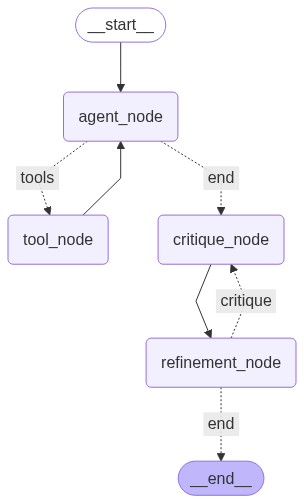

In [81]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [74]:
initial_state = {
    "messages": [{"role": "user", "content": "Can I get earphones for myself, a laptop bag for my wife and something cool for my kids?"}],
    "available_tools": tool_descriptions
}

final_state = None

for chunk in graph.stream(initial_state, stream_mode="values"):
    pprint(chunk)
    final_state = chunk


{
│   'messages': [
│   │   {
│   │   │   'role': 'user',
│   │   │   'content': 'Can I get earphones for myself, a laptop bag for my wife and something cool for my kids?'
│   │   }
│   ],
│   'available_tools': [
│   │   {
│   │   │   'name': 'get_formatted_context',
│   │   │   'description': 'Get the top k context, each representing an inventory item for a given query.',
│   │   │   'parameters': {
│   │   │   │   'type': 'object',
│   │   │   │   'properties': {
│   │   │   │   │   'query': {'type': 'string', 'description': 'The query to get the top k context for'},
│   │   │   │   │   'top_k': {
│   │   │   │   │   │   'type': 'integer',
│   │   │   │   │   │   'description': 'The number of context chunks to retrieve, works best with 5 or more',
│   │   │   │   │   │   'default': 5
│   │   │   │   │   }
│   │   │   │   }
│   │   │   },
│   │   │   'required': ['query'],
│   │   │   'returns': {
│   │   │   │   'type': 'string',
│   │   │   │   'description': 'A string of the top k context chunks with IDs prepending each chunk, each representing an inventory item for a given query.'
│   │   │   }
│   │   }
│   ],
│   'retrieved_context': [],
│   'critique': [],
│   'suggested_improvements': []
}

{
│   'messages': [
│   │   {
│   │   │   'role': 'user',
│   │   │   'content': 'Can I get earphones for myself, a laptop bag for my wife and something cool for my kids?'
│   │   },
│   │   AIMessage(
│   │   │   content='I will check the available products for earphones, laptop bags, and cool items for kids to provide you with suitable options.',
│   │   │   additional_kwargs={},
│   │   │   response_metadata={},
│   │   │   tool_calls=[
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'earphones', 'top_k': 5},
│   │   │   │   │   'id': 'call_0',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'laptop bag', 'top_k': 5},
│   │   │   │   │   'id': 'call_1',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'cool items for kids', 'top_k': 5},
│   │   │   │   │   'id': 'call_2',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   }
│   │   │   ]
│   │   )
│   ],
│   'iteration': 1,
│   'answer': 'I will check the available products for earphones, laptop bags, and cool items for kids to provide you with suitable options.',
│   'final_answer': False,
│   'available_tools': [
│   │   {
│   │   │   'name': 'get_formatted_context',
│   │   │   'description': 'Get the top k context, each representing an inventory item for a given query.',
│   │   │   'parameters': {
│   │   │   │   'type': 'object',
│   │   │   │   'properties': {
│   │   │   │   │   'query': {'type': 'string', 'description': 'The query to get the top k context for'},
│   │   │   │   │   'top_k': {
│   │   │   │   │   │   'type': 'integer',
│   │   │   │   │   │   'description': 'The number of context chunks to retrieve, works best with 5 or more',
│   │   │   │   │   │   'default': 5
│   │   │   │   │   }
│   │   │   │   }
│   │   │   },
│   │   │   'required': ['query'],
│   │   │   'returns': {
│   │   │   │   'type': 'string',
│   │   │   │   'description': 'A string of the top k context chunks with IDs prepending each chunk, each representing an inventory item for a given query.'
│   │   │   }
│   │   }
│   ],
│   'tool_calls': [
│   │   ToolCall(name='get_formatted_context', arguments={'query': 'earphones', 'top_k': 5}),
│   │   ToolCall(name='get_formatted_context', arguments={'query': 'laptop bag', 'top_k': 5}),
│   │   ToolCall(name='get_formatted_context', arguments={'query': 'cool items for kids', 'top_k': 5})
│   ],
│   'retrieved_context': [],
│   'critique': [],
│   'suggested_improvements': []
}

{
│   'messages': [
│   │   {
│   │   │   'role': 'user',
│   │   │   'content': 'Can I get earphones for myself, a laptop bag for my wife and something cool for my kids?'
│   │   },
│   │   AIMessage(
│   │   │   content='I will check the available products for earphones, laptop bags, and cool items for kids to provide you with suitable options.',
│   │   │   additional_kwargs={},
│   │   │   response_metadata={},
│   │   │   tool_calls=[
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'earphones', 'top_k': 5},
│   │   │   │   │   'id': 'call_0',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'laptop bag', 'top_k': 5},
│   │   │   │   │   'id': 'call_1',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'cool items for kids', 'top_k': 5},
│   │   │   │   │   'id': 'call_2',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   }
│   │   │   ]
│   │   ),
│   │   ToolMessage(
│   │   │   content="- 1: Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass in-Ear Earphones Premium Sound with Mic Wireless Charging Case for iPhone, Samsung, Android Smartphone Laptop Sports [Advanced Bluetooth Technology] Our earbuds adopt Bluetooth 5.3 technology, which greatly improves the transmission speed and provides a low-latency listening experience. With support for A2DP, AVRCP, HFP, and more, you can enjoy seamless connectivity and superb audio quality. [Enhanced Audio Experience] Immerse yourself in powerful, deep bass with our wireless earbuds. Designed to provide extra punch, warmth, and impact to keep you energized during your workout and deliver crystal-clear sound for a superior listening experience. [Long Battery Life] Enjoy up to 5 hours of playback time per earbud, and a total of over 22 hours (100% volume) when combined with the charging case. Enjoy a full day of listening enjoyment with just 1.5 hours of charging time. Charge easily with the included charging case and Type-C charging cable. [Comfortable and Secure Fit] Designed with a slim profile and a longer earbud stem, our wireless earbuds offer a more snug in-ear fit. This creates a perfect seal, improves sound quality, and ensures a comfortable and secure fit, making them ideal for active lifestyles and sports activities. [Convenient Touch Control] Our wireless earbuds have a smart touch control function, you can easily play/pause music, skip songs, activate voice assistant, and answer calls with just a tap of the earbuds. With the built-in microphone, you can experience clear calls even in noisy environments, and easily activate Siri or Google Assistant. \n- 11: IKG Wireless Earbuds, Bluetooth Headphones with Microphone, 30H Playtime with Transparent Charging Case, Deep Bass, IPX7 Waterproof, Earphones for Work Sport Game Ergonomic design and unique appearance: the weight of a single earbud is only 3.5g, round and smooth sound cavity design, 35 ° of the golden angle of entry into the ear, the curve of the body design of the fit to provide a good airtightness. Headphones wireless unique transparent cover and simple charging compartment design, easily adapt to different scenarios. Bluetooth 5.3 and automatic one-step connection: The in-ear headphones provide simultaneous binaural transmission through the use of Bluetooth 5.3 chip, increasing the connection speed by 80%. Dual-channel transmission technology for seamless switching between single/binaural modes. By opening the lid of the charging case, the Bluetooth headset can automatically connect to the previously paired device. Subwoofer and CVC8.0: The headset speaker uses a 13.4mm composite diaphragm with a large dynamic coil to create a spatial 3D panoramic sound effect, earbuds wirelessly improve sound quality by 90%, and su

KeyboardInterrupt: 

In [39]:
pprint(final_state)

{
│   'agent_node': {
│   │   'messages': [
│   │   │   AIMessage(
│   │   │   │   content='For earphones, we have several wireless earbuds options:\n- IKG Wireless Earbuds with Bluetooth 5.3, 30 hours playtime, IPX7 waterproof, touch control, deep bass, and automatic one-step connection. They include a transparent charging case and support audio HD decoding and CVC8.0 for clear calls.\n- Wireless Earbuds Bluetooth 5.3 with deep bass, 5 hours playback per earbud, total 22 hours with charging case, touch control, and comfortable secure fit.\n- Wireless Earbuds with 130 hours playtime, 2500mAh wireless charging case, LED display, Hi-Fi stereo bass, noise-canceling calls, IPX7 waterproof, and ergonomic lightweight earhooks.\n\nFor a laptop bag for your wife, we have:\n- MOSISO Laptop Sleeve compatible with MacBook Air/Pro 13-13.3 inch notebooks. It features garden flowers polyester material, a vertical side pocket, slim and lightweight design, polyester foam padding, and fluffy fleece fabric lining for protection against dust, dirt, bumps, and scratches.\n\nFor something cool for kids, we have:\n- 200PCS Anime Stickers Mixed Pack with trendy manga stickers, waterproof and sun-proof vinyl, suitable for decorating laptops, water bottles, notebooks, and more.\n- Compatible with Airpods Cases, Cute 3D Soft Silicone Cartoon Cool pods Case, shockproof and protective, suitable for kids, boys, girls, teens, and women.\n- OtterBox Made for Kids Case for iPad Mini (6th Gen) with durable construction, microbial growth blocking, fun colors, and a limited lifetime warranty.\n- VuyKoo Cat Ear Bluetooth Headphones with microphone, LED light-up, volume limiting for hearing protection, foldable and adjustable, Bluetooth 5.0 connection, built-in HD microphone, and suitable as a gift.\n- iPad Mini 6 Case for Kids, shockproof, lightweight, with comfort grip carrying handle and folding stand, designed for the new iPad Mini 6.\n\nPlease let me know if you want detailed specifications or to choose any specific product from these options.',
│   │   │   │   additional_kwargs={},
│   │   │   │   response_metadata={},
│   │   │   │   tool_calls=[
│   │   │   │   │   {
│   │   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   │   'args': {'query': 'earphones laptop bag cool kids items', 'top_k': 5},
│   │   │   │   │   │   'id': 'call_0',
│   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   }
│   │   │   │   ]
│   │   │   )
│   │   ],
│   │   'tool_calls': [
│   │   │   ToolCall(
│   │   │   │   name='get_formatted_context',
│   │   │   │   arguments={'query': 'earphones laptop bag cool kids items', 'top_k': 5}
│   │   │   )
│   │   ],
│   │   'iteration': 2,
│   │   'answer': 'For earphones, we have several wireless earbuds options:\n- IKG Wireless Earbuds with Bluetooth 5.3, 30 hours playtime, IPX7 waterproof, touch control, deep bass, and automatic one-step connection. They include a transparent charging case and support audio HD decoding and CVC8.0 for clear calls.\n- Wireless Earbuds Bluetooth 5.3 with deep bass, 5 hours playback per earbud, total 22 hours with charging case, touch control, and comfortable secure fit.\n- Wireless Earbuds with 130 hours playtime, 2500mAh wireless charging case, LED display, Hi-Fi stereo bass, noise-canceling calls, IPX7 waterproof, and ergonomic lightweight earhooks.\n\nFor a laptop bag for your wife, we have:\n- MOSISO Laptop Sleeve compatible with MacBook Air/Pro 13-13.3 inch notebooks. It features garden flowers polyester material, a vertical side pocket, slim and lightweight design, polyester foam padding, and fluffy fleece fabric lining for protection against dust, dirt, bumps, and scratches.\n\nFor something cool for kids, we have:\n- 200PCS Anime Stickers Mixed Pack with trendy manga stickers, waterproof and sun-proof vinyl, suitable for decorating laptops, water bottles, notebooks, and more.\n- Compatible with Airpods Cases, Cute 3D Soft Silicone Cartoon Cool pods Case, shockproof a

In [34]:
initial_state = {
    "messages": [{"role": "user", "content": "Can I get earphones for myself? Only after you have found any make another search for laptop case for my wife"}],
    "available_tools": tool_descriptions
}

for chunk in graph.stream(initial_state, stream_mode="debug"):
    pprint(chunk)

{
│   'step': 1,
│   'timestamp': '2025-07-26T13:57:24.454015+00:00',
│   'type': 'task',
│   'payload': {
│   │   'id': '2daab324-e458-5200-4091-d0041c4eb3dd',
│   │   'name': 'agent_node',
│   │   'input': State(
│   │   │   messages=[
│   │   │   │   {
│   │   │   │   │   'role': 'user',
│   │   │   │   │   'content': 'Can I get earphones for myself? Only after you have found any make another search for laptop case for my wife'
│   │   │   │   }
│   │   │   ],
│   │   │   iteration=0,
│   │   │   answer='',
│   │   │   final_answer=False,
│   │   │   available_tools=[
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'description': 'Get the top k context, each representing an inventory item for a given query.',
│   │   │   │   │   'parameters': {
│   │   │   │   │   │   'type': 'object',
│   │   │   │   │   │   'properties': {
│   │   │   │   │   │   │   'query': {'type': 'string', 'description': 'The query to get the top k context for'},
│   │   │   │   │   │   │   'top_k': {
│   │   │   │   │   │   │   │   'type': 'integer',
│   │   │   │   │   │   │   │   'description': 'The number of context chunks to retrieve, works best with 5 or more',
│   │   │   │   │   │   │   │   'default': 5
│   │   │   │   │   │   │   }
│   │   │   │   │   │   }
│   │   │   │   │   },
│   │   │   │   │   'required': ['query'],
│   │   │   │   │   'returns': {
│   │   │   │   │   │   'type': 'string',
│   │   │   │   │   │   'description': 'A string of the top k context chunks with IDs prepending each chunk, each representing an inventory item for a given query.'
│   │   │   │   │   }
│   │   │   │   }
│   │   │   ],
│   │   │   tool_calls=[],
│   │   │   retrieved_context=[]
│   │   ),
│   │   'triggers': ('branch:to:agent_node',)
│   }
}

{
│   'step': 1,
│   'timestamp': '2025-07-26T13:57:27.964527+00:00',
│   'type': 'task_result',
│   'payload': {
│   │   'id': '2daab324-e458-5200-4091-d0041c4eb3dd',
│   │   'name': 'agent_node',
│   │   'error': None,
│   │   'result': [
│   │   │   (
│   │   │   │   'messages',
│   │   │   │   [
│   │   │   │   │   AIMessage(
│   │   │   │   │   │   content='I will first search for earphones available in the inventory and then search for laptop cases for your wife.',
│   │   │   │   │   │   additional_kwargs={},
│   │   │   │   │   │   response_metadata={},
│   │   │   │   │   │   tool_calls=[
│   │   │   │   │   │   │   {
│   │   │   │   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   │   │   │   'args': {'query': 'earphones', 'top_k': 5},
│   │   │   │   │   │   │   │   'id': 'call_0',
│   │   │   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   │   │   }
│   │   │   │   │   │   ]
│   │   │   │   │   )
│   │   │   │   ]
│   │   │   ),
│   │   │   (
│   │   │   │   'tool_calls',
│   │   │   │   [ToolCall(name='get_formatted_context', arguments={'query': 'earphones', 'top_k': 5})]
│   │   │   ),
│   │   │   ('iteration', 1),
│   │   │   (
│   │   │   │   'answer',
│   │   │   │   'I will first search for earphones available in the inventory and then search for laptop cases for your wife.'
│   │   │   ),
│   │   │   ('final_answer', False),
│   │   │   ('retrieved_context', [])
│   │   ],
│   │   'interrupts': []
│   }
}

{
│   'step': 2,
│   'timestamp': '2025-07-26T13:57:27.964617+00:00',
│   'type': 'task',
│   'payload': {
│   │   'id': '8494be18-a449-4ac8-9cac-3451fb39d19c',
│   │   'name': 'tool_node',
│   │   'input': State(
│   │   │   messages=[
│   │   │   │   {
│   │   │   │   │   'role': 'user',
│   │   │   │   │   'content': 'Can I get earphones for myself? Only after you have found any make another search for laptop case for my wife'
│   │   │   │   },
│   │   │   │   AIMessage(
│   │   │   │   │   content='I will first search for earphones available in the inventory and then search for laptop cases for your wife.',
│   │   │   │   │   additional_kwargs={},
│   │   │   │   │   response_metadata={},
│   │   │   │   │   tool_calls=[
│   │   │   │   │   │   {
│   │   │   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   │   │   'args': {'query': 'earphones', 'top_k': 5},
│   │   │   │   │   │   │   'id': 'call_0',
│   │   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   │   }
│   │   │   │   │   ]
│   │   │   │   )
│   │   │   ],
│   │   │   iteration=1,
│   │   │   answer='I will first search for earphones available in the inventory and then search for laptop cases for your wife.',
│   │   │   final_answer=False,
│   │   │   available_tools=[
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'description': 'Get the top k context, each representing an inventory item for a given query.',
│   │   │   │   │   'parameters': {
│   │   │   │   │   │   'type': 'object',
│   │   │   │   │   │   'properties': {
│   │   │   │   │   │   │   'query': {'type': 'string', 'description': 'The query to get the top k context for'},
│   │   │   │   │   │   │   'top_k': {
│   │   │   │   │   │   │   │   'type': 'integer',
│   │   │   │   │   │   │   │   'description': 'The number of context chunks to retrieve, works best with 5 or more',
│   │   │   │   │   │   │   │   'default': 5
│   │   │   │   │   │   │   }
│   │   │   │   │   │   }
│   │   │   │   │   },
│   │   │   │   │   'required': ['query'],
│   │   │   │   │   'returns': {
│   │   │   │   │   │   'type': 'string',
│   │   │   │   │   │   'description': 'A string of the top k context chunks with IDs prepending each chunk, each representing an inventory item for a given query.'
│   │   │   │   │   }
│   │   │   │   }
│   │   │   ],
│   │   │   tool_calls=[ToolCall(name='get_formatted_context', arguments={'query': 'earphones', 'top_k': 5})],
│   │   │   retrieved_context=[]
│   │   ),
│   │   'triggers': ('branch:to:tool_node',)
│   }
}

2025-07-26 15:57:27,971 INFO Notebook 1 Getting formatted context for query: earphones
2025-07-26 15:57:28,221 INFO Notebook 1 Fusion enabled. Retrieving for query: earphones top 5 results from Amazon-items-collection-01-hybrid collection
2025-07-26 15:57:28,248 INFO Notebook 1 Retrieved 5 results


{
│   'step': 2,
│   'timestamp': '2025-07-26T13:57:28.251157+00:00',
│   'type': 'task_result',
│   'payload': {
│   │   'id': '8494be18-a449-4ac8-9cac-3451fb39d19c',
│   │   'name': 'tool_node',
│   │   'error': None,
│   │   'result': [
│   │   │   (
│   │   │   │   'messages',
│   │   │   │   [
│   │   │   │   │   ToolMessage(
│   │   │   │   │   │   content="- 1: Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass in-Ear Earphones Premium Sound with Mic Wireless Charging Case for iPhone, Samsung, Android Smartphone Laptop Sports [Advanced Bluetooth Technology] Our earbuds adopt Bluetooth 5.3 technology, which greatly improves the transmission speed and provides a low-latency listening experience. With support for A2DP, AVRCP, HFP, and more, you can enjoy seamless connectivity and superb audio quality. [Enhanced Audio Experience] Immerse yourself in powerful, deep bass with our wireless earbuds. Designed to provide extra punch, warmth, and impact to keep you energized during your workout and deliver crystal-clear sound for a superior listening experience. [Long Battery Life] Enjoy up to 5 hours of playback time per earbud, and a total of over 22 hours (100% volume) when combined with the charging case. Enjoy a full day of listening enjoyment with just 1.5 hours of charging time. Charge easily with the included charging case and Type-C charging cable. [Comfortable and Secure Fit] Designed with a slim profile and a longer earbud stem, our wireless earbuds offer a more snug in-ear fit. This creates a perfect seal, improves sound quality, and ensures a comfortable and secure fit, making them ideal for active lifestyles and sports activities. [Convenient Touch Control] Our wireless earbuds have a smart touch control function, you can easily play/pause music, skip songs, activate voice assistant, and answer calls with just a tap of the earbuds. With the built-in microphone, you can experience clear calls even in noisy environments, and easily activate Siri or Google Assistant. \n- 11: IKG Wireless Earbuds, Bluetooth Headphones with Microphone, 30H Playtime with Transparent Charging Case, Deep Bass, IPX7 Waterproof, Earphones for Work Sport Game Ergonomic design and unique appearance: the weight of a single earbud is only 3.5g, round and smooth sound cavity design, 35 ° of the golden angle of entry into the ear, the curve of the body design of the fit to provide a good airtightness. Headphones wireless unique transparent cover and simple charging compartment design, easily adapt to different scenarios. Bluetooth 5.3 and automatic one-step connection: The in-ear headphones provide simultaneous binaural transmission through the use of Bluetooth 5.3 chip, increasing the connection speed by 80%. Dual-channel transmission technology for seamless switching between single/binaural modes. By opening the lid of the charging case, the Bluetooth headset can automatically connect to the previously paired device. Subwoofer and CVC8.0: The headset speaker uses a 13.4mm composite diaphragm with a large dynamic coil to create a spatial 3D panoramic sound effect, earbuds wirelessly improve sound quality by 90%, and support for audio HD decoding and CVC8.0 lets you enjoy clear calls. Equipped with an optical infrared sensor to support in-ear recognition. Touch operation, IPX7 waterproof: Wireless headphones can easily control volume, songs, calls and voice assistants with a simple touch of a finger on the side of the headphone shaft, and the controls can be used completely off the phone. IPX7 waterproof earbuds, rain and sweat resistant, BTW86 wireless earbuds are a great helper when playing sports. Type-C fast charging, 30 hours of life: The wireless headphone charging case is equipped with a Type-C charging port, which increases the charging speed by 2 times and can be easily charged in 10 minutes and used for 1 hour. The headphones and charging case can last up to 30 hours. \n- 24: Wireless Earbuds Bluetooth Headphones 130Hrs Playtime with 2500

{
│   'step': 3,
│   'timestamp': '2025-07-26T13:57:28.251333+00:00',
│   'type': 'task',
│   'payload': {
│   │   'id': 'ba72091f-3370-2f48-f227-e13d33f0ca40',
│   │   'name': 'agent_node',
│   │   'input': State(
│   │   │   messages=[
│   │   │   │   {
│   │   │   │   │   'role': 'user',
│   │   │   │   │   'content': 'Can I get earphones for myself? Only after you have found any make another search for laptop case for my wife'
│   │   │   │   },
│   │   │   │   AIMessage(
│   │   │   │   │   content='I will first search for earphones available in the inventory and then search for laptop cases for your wife.',
│   │   │   │   │   additional_kwargs={},
│   │   │   │   │   response_metadata={},
│   │   │   │   │   tool_calls=[
│   │   │   │   │   │   {
│   │   │   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   │   │   'args': {'query': 'earphones', 'top_k': 5},
│   │   │   │   │   │   │   'id': 'call_0',
│   │   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   │   }
│   │   │   │   │   ]
│   │   │   │   ),
│   │   │   │   ToolMessage(
│   │   │   │   │   content="- 1: Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass in-Ear Earphones Premium Sound with Mic Wireless Charging Case for iPhone, Samsung, Android Smartphone Laptop Sports [Advanced Bluetooth Technology] Our earbuds adopt Bluetooth 5.3 technology, which greatly improves the transmission speed and provides a low-latency listening experience. With support for A2DP, AVRCP, HFP, and more, you can enjoy seamless connectivity and superb audio quality. [Enhanced Audio Experience] Immerse yourself in powerful, deep bass with our wireless earbuds. Designed to provide extra punch, warmth, and impact to keep you energized during your workout and deliver crystal-clear sound for a superior listening experience. [Long Battery Life] Enjoy up to 5 hours of playback time per earbud, and a total of over 22 hours (100% volume) when combined with the charging case. Enjoy a full day of listening enjoyment with just 1.5 hours of charging time. Charge easily with the included charging case and Type-C charging cable. [Comfortable and Secure Fit] Designed with a slim profile and a longer earbud stem, our wireless earbuds offer a more snug in-ear fit. This creates a perfect seal, improves sound quality, and ensures a comfortable and secure fit, making them ideal for active lifestyles and sports activities. [Convenient Touch Control] Our wireless earbuds have a smart touch control function, you can easily play/pause music, skip songs, activate voice assistant, and answer calls with just a tap of the earbuds. With the built-in microphone, you can experience clear calls even in noisy environments, and easily activate Siri or Google Assistant. \n- 11: IKG Wireless Earbuds, Bluetooth Headphones with Microphone, 30H Playtime with Transparent Charging Case, Deep Bass, IPX7 Waterproof, Earphones for Work Sport Game Ergonomic design and unique appearance: the weight of a single earbud is only 3.5g, round and smooth sound cavity design, 35 ° of the golden angle of entry into the ear, the curve of the body design of the fit to provide a good airtightness. Headphones wireless unique transparent cover and simple charging compartment design, easily adapt to different scenarios. Bluetooth 5.3 and automatic one-step connection: The in-ear headphones provide simultaneous binaural transmission through the use of Bluetooth 5.3 chip, increasing the connection speed by 80%. Dual-channel transmission technology for seamless switching between single/binaural modes. By opening the lid of the charging case, the Bluetooth headset can automatically connect to the previously paired device. Subwoofer and CVC8.0: The headset speaker uses a 13.4mm composite diaphragm with a large dynamic coil to create a spatial 3D panoramic sound effect, earbuds wirelessly improve sound quality by 90%, and support for audio HD decoding and CVC8.0 lets you enjoy clear calls. Equipped with an optical infra

{
│   'step': 3,
│   'timestamp': '2025-07-26T13:58:02.457303+00:00',
│   'type': 'task_result',
│   'payload': {
│   │   'id': 'ba72091f-3370-2f48-f227-e13d33f0ca40',
│   │   'name': 'agent_node',
│   │   'error': None,
│   │   'result': [
│   │   │   (
│   │   │   │   'messages',
│   │   │   │   [
│   │   │   │   │   AIMessage(
│   │   │   │   │   │   content='There are several earphones available for you:\n\n1. Wireless Earbuds Bluetooth 5.3 Headphones with Deep Bass, Wireless Charging Case, and Touch Control:\n- Bluetooth 5.3 technology for fast transmission and low latency\n- Deep bass sound with crystal-clear audio\n- Up to 5 hours playback per earbud, 22 hours total with charging case\n- Comfortable and secure fit for active lifestyles\n- Smart touch control for music, calls, and voice assistant\n\n2. IKG Wireless Earbuds with Microphone, 30H Playtime, Transparent Charging Case, Deep Bass, IPX7 Waterproof:\n- Ergonomic design with 3.5g weight per earbud\n- Bluetooth 5.3 with automatic one-step connection\n- 13.4mm composite diaphragm speaker for 3D sound\n- Touch operation and IPX7 waterproof\n- Type-C fast charging, 30 hours total playtime\n\n3. Wireless Earbuds Bluetooth Headphones with 130H Playtime, 2500mAh Wireless Charging Case, LED Display, Hi-Fi Stereo Bass:\n- 2500mAh charging case for 16 full charges\n- 8 hours playback per earbud\n- Noise-canceling calls\n- One-step pairing technology\n- Ergonomic silicone earhooks, IPX7 waterproof\n\n4. EYIW 2 Pack Headphone Adapter for iPhone:\n- Apple MFi Certified\n- Lightning to 3.5mm earphone audio and charger splitter\n- Supports all iOS devices\n- High-quality sound with 48KHz and 24-bit audio output\n\n5. RP-TCM125-A in-Ear Buds with Mic & Remote for Smartphone:\n- Ergonomic design for ear canal\n- S/M/L sized soft ear pieces\n- 1.1m cord length\n- Frequency response 10Hz - 24kHz\n\nNow, I will search for laptop cases for your wife.',
│   │   │   │   │   │   additional_kwargs={},
│   │   │   │   │   │   response_metadata={},
│   │   │   │   │   │   tool_calls=[
│   │   │   │   │   │   │   {
│   │   │   │   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   │   │   │   'args': {'query': 'laptop case', 'top_k': 5},
│   │   │   │   │   │   │   │   'id': 'call_0',
│   │   │   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   │   │   }
│   │   │   │   │   │   ]
│   │   │   │   │   )
│   │   │   │   ]
│   │   │   ),
│   │   │   (
│   │   │   │   'tool_calls',
│   │   │   │   [ToolCall(name='get_formatted_context', arguments={'query': 'laptop case', 'top_k': 5})]
│   │   │   ),
│   │   │   ('iteration', 2),
│   │   │   (
│   │   │   │   'answer',
│   │   │   │   'There are several earphones available for you:\n\n1. Wireless Earbuds Bluetooth 5.3 Headphones with Deep Bass, Wireless Charging Case, and Touch Control:\n- Bluetooth 5.3 technology for fast transmission and low latency\n- Deep bass sound with crystal-clear audio\n- Up to 5 hours playback per earbud, 22 hours total with charging case\n- Comfortable and secure fit for active lifestyles\n- Smart touch control for music, calls, and voice assistant\n\n2. IKG Wireless Earbuds with Microphone, 30H Playtime, Transparent Charging Case, Deep Bass, IPX7 Waterproof:\n- Ergonomic design with 3.5g weight per earbud\n- Bluetooth 5.3 with automatic one-step connection\n- 13.4mm composite diaphragm speaker for 3D sound\n- Touch operation and IPX7 waterproof\n- Type-C fast charging, 30 hours total playtime\n\n3. Wireless Earbuds Bluetooth Headphones with 130H Playtime, 2500mAh Wireless Charging Case, LED Display, Hi-Fi Stereo Bass:\n- 2500mAh charging case for 16 full charges\n- 8 hours playback per earbud\n- Noise-canceling calls\n- One-step pairing technology\n- Ergonomic silicone earhooks, IPX7 waterproof\n\n4. EYIW 2 Pack Headphone Adapter for iPhone:\n- Apple MFi Certified\n- Lightning to 3.5mm earphone audio and charger splitter\n- Supports all iOS devices\n- High-quality sound with 48KHz and 24-bi

{
│   'step': 4,
│   'timestamp': '2025-07-26T13:58:02.457513+00:00',
│   'type': 'task',
│   'payload': {
│   │   'id': '9d9a105e-423b-c161-d0fb-3a374acd386a',
│   │   'name': 'tool_node',
│   │   'input': State(
│   │   │   messages=[
│   │   │   │   {
│   │   │   │   │   'role': 'user',
│   │   │   │   │   'content': 'Can I get earphones for myself? Only after you have found any make another search for laptop case for my wife'
│   │   │   │   },
│   │   │   │   AIMessage(
│   │   │   │   │   content='I will first search for earphones available in the inventory and then search for laptop cases for your wife.',
│   │   │   │   │   additional_kwargs={},
│   │   │   │   │   response_metadata={},
│   │   │   │   │   tool_calls=[
│   │   │   │   │   │   {
│   │   │   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   │   │   'args': {'query': 'earphones', 'top_k': 5},
│   │   │   │   │   │   │   'id': 'call_0',
│   │   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   │   }
│   │   │   │   │   ]
│   │   │   │   ),
│   │   │   │   ToolMessage(
│   │   │   │   │   content="- 1: Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass in-Ear Earphones Premium Sound with Mic Wireless Charging Case for iPhone, Samsung, Android Smartphone Laptop Sports [Advanced Bluetooth Technology] Our earbuds adopt Bluetooth 5.3 technology, which greatly improves the transmission speed and provides a low-latency listening experience. With support for A2DP, AVRCP, HFP, and more, you can enjoy seamless connectivity and superb audio quality. [Enhanced Audio Experience] Immerse yourself in powerful, deep bass with our wireless earbuds. Designed to provide extra punch, warmth, and impact to keep you energized during your workout and deliver crystal-clear sound for a superior listening experience. [Long Battery Life] Enjoy up to 5 hours of playback time per earbud, and a total of over 22 hours (100% volume) when combined with the charging case. Enjoy a full day of listening enjoyment with just 1.5 hours of charging time. Charge easily with the included charging case and Type-C charging cable. [Comfortable and Secure Fit] Designed with a slim profile and a longer earbud stem, our wireless earbuds offer a more snug in-ear fit. This creates a perfect seal, improves sound quality, and ensures a comfortable and secure fit, making them ideal for active lifestyles and sports activities. [Convenient Touch Control] Our wireless earbuds have a smart touch control function, you can easily play/pause music, skip songs, activate voice assistant, and answer calls with just a tap of the earbuds. With the built-in microphone, you can experience clear calls even in noisy environments, and easily activate Siri or Google Assistant. \n- 11: IKG Wireless Earbuds, Bluetooth Headphones with Microphone, 30H Playtime with Transparent Charging Case, Deep Bass, IPX7 Waterproof, Earphones for Work Sport Game Ergonomic design and unique appearance: the weight of a single earbud is only 3.5g, round and smooth sound cavity design, 35 ° of the golden angle of entry into the ear, the curve of the body design of the fit to provide a good airtightness. Headphones wireless unique transparent cover and simple charging compartment design, easily adapt to different scenarios. Bluetooth 5.3 and automatic one-step connection: The in-ear headphones provide simultaneous binaural transmission through the use of Bluetooth 5.3 chip, increasing the connection speed by 80%. Dual-channel transmission technology for seamless switching between single/binaural modes. By opening the lid of the charging case, the Bluetooth headset can automatically connect to the previously paired device. Subwoofer and CVC8.0: The headset speaker uses a 13.4mm composite diaphragm with a large dynamic coil to create a spatial 3D panoramic sound effect, earbuds wirelessly improve sound quality by 90%, and support for audio HD decoding and CVC8.0 lets you enjoy clear calls. Equipped with an optical infrar

2025-07-26 15:58:02,475 INFO Notebook 1 Getting formatted context for query: laptop case
2025-07-26 15:58:02,793 INFO Notebook 1 Fusion enabled. Retrieving for query: laptop case top 5 results from Amazon-items-collection-01-hybrid collection
2025-07-26 15:58:02,811 INFO Notebook 1 Retrieved 5 results


{
│   'step': 4,
│   'timestamp': '2025-07-26T13:58:02.814725+00:00',
│   'type': 'task_result',
│   'payload': {
│   │   'id': '9d9a105e-423b-c161-d0fb-3a374acd386a',
│   │   'name': 'tool_node',
│   │   'error': None,
│   │   'result': [
│   │   │   (
│   │   │   │   'messages',
│   │   │   │   [
│   │   │   │   │   ToolMessage(
│   │   │   │   │   │   content='- 28: MOSISO Laptop Sleeve Compatible with MacBook Air/Pro, 13-13.3 inch Notebook, Compatible with MacBook Pro 14 inch 2023-2021 A2779 M2 A2442 M1, Garden Flowers Polyester Vertical Bag with Pocket, Grey Internal dimensions: 13.58 x 0.79 x 10.04 inches (L x W x H); External dimensions: 14.17 x 0.79 x 10.63 inches (L x W x H). The front vertical side pocket dimensions: 9.25 x 9.84 inches (L x W). Made with garden flowers polyester material, a top opening zipper gliding smoothly and allows convenient access to your device. Slim and lightweight, does not bulk your device up and can easily slide into your briefcase, backpack or other bag. Extra pocket in front provides enough space to keep mouse, earphone, pens and notepads, offering added convenience. This protective carrying sleeve case cover bag with pocket is ideal for you to take your laptop out. Features a polyester foam padding layer and fluffy fleece fabric lining for bump and shock absorption and protection of your device against dust, dirt, bump, shock and accidental scratches. Compatible with MacBook Pro 14 inch 2021-2023 A2779 M2 A2442 M1 Pro/Max Touch ID, compatible with MacBook Air 13 inch A1369 A1466 2010-2017, compatible with MacBook Pro 13 inch A1425 A1502 A1278 2008-2015; Compatible with Surface Book 3/2/1 13.5, compatible with Surface Laptop 4/3/2/1 13.5; Compatible with Dell Latitude 14; Compatible with HP Elitebook 13.3/Spectre X360 13.3/Envy 13/Stream 13/Stream 14/Pavilion 14; Compatible with Lenovo ThinkPad X1 Carbon; compatible with Lenovo IdeaPad 13/14. \n- 1: Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass in-Ear Earphones Premium Sound with Mic Wireless Charging Case for iPhone, Samsung, Android Smartphone Laptop Sports [Advanced Bluetooth Technology] Our earbuds adopt Bluetooth 5.3 technology, which greatly improves the transmission speed and provides a low-latency listening experience. With support for A2DP, AVRCP, HFP, and more, you can enjoy seamless connectivity and superb audio quality. [Enhanced Audio Experience] Immerse yourself in powerful, deep bass with our wireless earbuds. Designed to provide extra punch, warmth, and impact to keep you energized during your workout and deliver crystal-clear sound for a superior listening experience. [Long Battery Life] Enjoy up to 5 hours of playback time per earbud, and a total of over 22 hours (100% volume) when combined with the charging case. Enjoy a full day of listening enjoyment with just 1.5 hours of charging time. Charge easily with the included charging case and Type-C charging cable. [Comfortable and Secure Fit] Designed with a slim profile and a longer earbud stem, our wireless earbuds offer a more snug in-ear fit. This creates a perfect seal, improves sound quality, and ensures a comfortable and secure fit, making them ideal for active lifestyles and sports activities. [Convenient Touch Control] Our wireless earbuds have a smart touch control function, you can easily play/pause music, skip songs, activate voice assistant, and answer calls with just a tap of the earbuds. With the built-in microphone, you can experience clear calls even in noisy environments, and easily activate Siri or Google Assistant. \n- 10: 200PCS Anime Stickers Mixed Pack,Trendy Various Manga Stickers Vinyl Decals for Hydroflask Water Bottles Book MacBook Laptop Phone Case 200PCS different Anime stickers in each pack.Size:2- 4inch. COOL PATTERN: These trendy mixed anime stickers are great for teen girls,boys, kids! The stickers pack is also your right choice when choosing a gift for your friends, kids. WORKS ON ALL DIFFERENT TYPES OF SURFACES: Perfect to Laptops

{
│   'step': 5,
│   'timestamp': '2025-07-26T13:58:02.814930+00:00',
│   'type': 'task',
│   'payload': {
│   │   'id': '35455735-ba0d-9208-373d-3c616ea9f7cd',
│   │   'name': 'agent_node',
│   │   'input': State(
│   │   │   messages=[
│   │   │   │   {
│   │   │   │   │   'role': 'user',
│   │   │   │   │   'content': 'Can I get earphones for myself? Only after you have found any make another search for laptop case for my wife'
│   │   │   │   },
│   │   │   │   AIMessage(
│   │   │   │   │   content='I will first search for earphones available in the inventory and then search for laptop cases for your wife.',
│   │   │   │   │   additional_kwargs={},
│   │   │   │   │   response_metadata={},
│   │   │   │   │   tool_calls=[
│   │   │   │   │   │   {
│   │   │   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   │   │   'args': {'query': 'earphones', 'top_k': 5},
│   │   │   │   │   │   │   'id': 'call_0',
│   │   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   │   }
│   │   │   │   │   ]
│   │   │   │   ),
│   │   │   │   ToolMessage(
│   │   │   │   │   content="- 1: Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass in-Ear Earphones Premium Sound with Mic Wireless Charging Case for iPhone, Samsung, Android Smartphone Laptop Sports [Advanced Bluetooth Technology] Our earbuds adopt Bluetooth 5.3 technology, which greatly improves the transmission speed and provides a low-latency listening experience. With support for A2DP, AVRCP, HFP, and more, you can enjoy seamless connectivity and superb audio quality. [Enhanced Audio Experience] Immerse yourself in powerful, deep bass with our wireless earbuds. Designed to provide extra punch, warmth, and impact to keep you energized during your workout and deliver crystal-clear sound for a superior listening experience. [Long Battery Life] Enjoy up to 5 hours of playback time per earbud, and a total of over 22 hours (100% volume) when combined with the charging case. Enjoy a full day of listening enjoyment with just 1.5 hours of charging time. Charge easily with the included charging case and Type-C charging cable. [Comfortable and Secure Fit] Designed with a slim profile and a longer earbud stem, our wireless earbuds offer a more snug in-ear fit. This creates a perfect seal, improves sound quality, and ensures a comfortable and secure fit, making them ideal for active lifestyles and sports activities. [Convenient Touch Control] Our wireless earbuds have a smart touch control function, you can easily play/pause music, skip songs, activate voice assistant, and answer calls with just a tap of the earbuds. With the built-in microphone, you can experience clear calls even in noisy environments, and easily activate Siri or Google Assistant. \n- 11: IKG Wireless Earbuds, Bluetooth Headphones with Microphone, 30H Playtime with Transparent Charging Case, Deep Bass, IPX7 Waterproof, Earphones for Work Sport Game Ergonomic design and unique appearance: the weight of a single earbud is only 3.5g, round and smooth sound cavity design, 35 ° of the golden angle of entry into the ear, the curve of the body design of the fit to provide a good airtightness. Headphones wireless unique transparent cover and simple charging compartment design, easily adapt to different scenarios. Bluetooth 5.3 and automatic one-step connection: The in-ear headphones provide simultaneous binaural transmission through the use of Bluetooth 5.3 chip, increasing the connection speed by 80%. Dual-channel transmission technology for seamless switching between single/binaural modes. By opening the lid of the charging case, the Bluetooth headset can automatically connect to the previously paired device. Subwoofer and CVC8.0: The headset speaker uses a 13.4mm composite diaphragm with a large dynamic coil to create a spatial 3D panoramic sound effect, earbuds wirelessly improve sound quality by 90%, and support for audio HD decoding and CVC8.0 lets you enjoy clear calls. Equipped with an optical infra

{
│   'step': 5,
│   'timestamp': '2025-07-26T13:59:52.858334+00:00',
│   'type': 'task_result',
│   'payload': {
│   │   'id': '35455735-ba0d-9208-373d-3c616ea9f7cd',
│   │   'name': 'agent_node',
│   │   'error': None,
│   │   'result': [
│   │   │   (
│   │   │   │   'messages',
│   │   │   │   [
│   │   │   │   │   AIMessage(
│   │   │   │   │   │   content='For yourself, there are various earphones available:\n\n1. Wireless Earbuds Bluetooth 5.3 Headphones with Deep Bass, Wireless Charging Case, and Touch Control:\n- Bluetooth 5.3 technology for fast transmission and low latency\n- Deep bass sound with crystal-clear audio\n- Up to 5 hours playback per earbud, 22 hours total with charging case\n- Comfortable and secure fit for active lifestyles\n- Smart touch control for music, calls, and voice assistant\n\n2. IKG Wireless Earbuds with Microphone, 30H Playtime, Transparent Charging Case, Deep Bass, IPX7 Waterproof:\n- Ergonomic design with 3.5g weight per earbud\n- Bluetooth 5.3 with automatic one-step connection\n- 13.4mm composite diaphragm speaker for 3D sound\n- Touch operation and IPX7 waterproof\n- Type-C fast charging, 30 hours total playtime\n\n3. Wireless Earbuds Bluetooth Headphones with 130H Playtime, 2500mAh Wireless Charging Case, LED Display, Hi-Fi Stereo Bass:\n- 2500mAh charging case for 16 full charges\n- 8 hours playback per earbud\n- Noise-canceling calls\n- One-step pairing technology\n- Ergonomic silicone earhooks, IPX7 waterproof\n\n4. EYIW 2 Pack Headphone Adapter for iPhone:\n- Apple MFi Certified\n- Lightning to 3.5mm earphone audio and charger splitter\n- Supports all iOS devices\n- High-quality sound with 48KHz and 24-bit audio output\n\n5. RP-TCM125-A in-Ear Buds with Mic & Remote for Smartphone:\n- Ergonomic design for ear canal\n- S/M/L sized soft ear pieces\n- 1.1m cord length\n- Frequency response 10Hz - 24kHz\n\nFor your wife, there is a MOSISO Laptop Sleeve suitable for MacBook Air/Pro 13-13.3 inch and other compatible laptops:\n- Internal dimensions: 13.58 x 0.79 x 10.04 inches\n- External dimensions: 14.17 x 0.79 x 10.63 inches\n- Front vertical side pocket for mouse, earphone, pens, and notepads\n- Made with garden flowers polyester material\n- Slim and lightweight design\n- Polyester foam padding and fleece fabric lining for protection\n- Compatible with various MacBook models, Surface Book, Dell Latitude, HP Elitebook, Lenovo ThinkPad, and IdeaPad\n\nLet me know if you want more details on any of these products or want to proceed with a purchase.',
│   │   │   │   │   │   additional_kwargs={},
│   │   │   │   │   │   response_metadata={},
│   │   │   │   │   │   tool_calls=[
│   │   │   │   │   │   │   {
│   │   │   │   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   │   │   │   'args': {'query': 'earphones', 'top_k': 5},
│   │   │   │   │   │   │   │   'id': 'call_0',
│   │   │   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   │   │   },
│   │   │   │   │   │   │   {
│   │   │   │   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   │   │   │   'args': {'query': 'laptop case', 'top_k': 5},
│   │   │   │   │   │   │   │   'id': 'call_1',
│   │   │   │   │   │   │   │   'type': 'tool_call'
│   │   │   │   │   │   │   }
│   │   │   │   │   │   ]
│   │   │   │   │   )
│   │   │   │   ]
│   │   │   ),
│   │   │   (
│   │   │   │   'tool_calls',
│   │   │   │   [
│   │   │   │   │   ToolCall(name='get_formatted_context', arguments={'query': 'earphones', 'top_k': 5}),
│   │   │   │   │   ToolCall(name='get_formatted_context', arguments={'query': 'laptop case', 'top_k': 5})
│   │   │   │   ]
│   │   │   ),
│   │   │   ('iteration', 3),
│   │   │   (
│   │   │   │   'answer',
│   │   │   │   'For yourself, there are various earphones available:\n\n1. Wireless Earbuds Bluetooth 5.3 Headphones with Deep Bass, Wireless Charging Case, and Touch Control:\n- Bluetooth 5.3 technology for fast transmission and low latency\n- Deep bass sound with crys

In [17]:


for data in result['messages']:
    pprint(data)

{
│   'role': 'user',
│   'content': 'Can I get earphones for myself, a laptop bag for my wife and something cool for my kids?'
}

AIMessage(
│   content='I will check the available products for earphones, laptop bags, and cool items for kids.',
│   additional_kwargs={},
│   response_metadata={},
│   tool_calls=[
│   │   {
│   │   │   'name': 'get_formatted_context',
│   │   │   'args': {'query': 'earphones', 'top_k': 5},
│   │   │   'id': 'call_0',
│   │   │   'type': 'tool_call'
│   │   },
│   │   {
│   │   │   'name': 'get_formatted_context',
│   │   │   'args': {'query': 'laptop bag', 'top_k': 5},
│   │   │   'id': 'call_1',
│   │   │   'type': 'tool_call'
│   │   },
│   │   {
│   │   │   'name': 'get_formatted_context',
│   │   │   'args': {'query': 'cool items for kids', 'top_k': 5},
│   │   │   'id': 'call_2',
│   │   │   'type': 'tool_call'
│   │   }
│   ]
)

ToolMessage(
│   content="- 11: IKG Wireless Earbuds, Bluetooth Headphones with Microphone, 30H Playtime with Transparent Charging Case, Deep Bass, IPX7 Waterproof, Earphones for Work Sport Game Ergonomic design and unique appearance: the weight of a single earbud is only 3.5g, round and smooth sound cavity design, 35 ° of the golden angle of entry into the ear, the curve of the body design of the fit to provide a good airtightness. Headphones wireless unique transparent cover and simple charging compartment design, easily adapt to different scenarios. Bluetooth 5.3 and automatic one-step connection: The in-ear headphones provide simultaneous binaural transmission through the use of Bluetooth 5.3 chip, increasing the connection speed by 80%. Dual-channel transmission technology for seamless switching between single/binaural modes. By opening the lid of the charging case, the Bluetooth headset can automatically connect to the previously paired device. Subwoofer and CVC8.0: The headset speaker uses a 13.4mm composite diaphragm with a large dynamic coil to create a spatial 3D panoramic sound effect, earbuds wirelessly improve sound quality by 90%, and support for audio HD decoding and CVC8.0 lets you enjoy clear calls. Equipped with an optical infrared sensor to support in-ear recognition. Touch operation, IPX7 waterproof: Wireless headphones can easily control volume, songs, calls and voice assistants with a simple touch of a finger on the side of the headphone shaft, and the controls can be used completely off the phone. IPX7 waterproof earbuds, rain and sweat resistant, BTW86 wireless earbuds are a great helper when playing sports. Type-C fast charging, 30 hours of life: The wireless headphone charging case is equipped with a Type-C charging port, which increases the charging speed by 2 times and can be easily charged in 10 minutes and used for 1 hour. The headphones and charging case can last up to 30 hours. \n- 1: Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass in-Ear Earphones Premium Sound with Mic Wireless Charging Case for iPhone, Samsung, Android Smartphone Laptop Sports [Advanced Bluetooth Technology] Our earbuds adopt Bluetooth 5.3 technology, which greatly improves the transmission speed and provides a low-latency listening experience. With support for A2DP, AVRCP, HFP, and more, you can enjoy seamless connectivity and superb audio quality. [Enhanced Audio Experience] Immerse yourself in powerful, deep bass with our wireless earbuds. Designed to provide extra punch, warmth, and impact to keep you energized during your workout and deliver crystal-clear sound for a superior listening experience. [Long Battery Life] Enjoy up to 5 hours of playback time per earbud, and a total of over 22 hours (100% volume) when combined with the charging case. Enjoy a full day of listening enjoyment with just 1.5 hours of charging time. Charge easily with the included charging case and Type-C charging cable. [Comfortable and Secure Fit] Designed with a slim profile and a longer earbud stem, our wireless earbuds offer a more snug in-ear fit. This creates a perfect seal, improves sound quality, and ensures a comfortable and secure fit, making them ideal for active lifestyles and sports activities. [Convenient Touch Control] Our wireless earbuds have a smart touch control function, you can easily play/pause music, skip songs, activate voice assistant, and answer calls with just a tap of the earbuds. With the built-in microphone, you can experience clear calls even in noisy environments, and easily activate Siri or Google Assistant. \n- 24: Wireless Earbuds Bluetooth Headphones 130Hrs Playtime with 2500mAh Wireless Charging Case LED Diaplay Hi-Fi Waterproof Over Ear Earphones for Sports Running Workout Gaming Wireless Charging Case with LED Display: 2500mAh charging case supports 16 times fully charging for wireless earbuds and let you enjoy more than 130 hours music time. Each earbud can get 8hrs playback on a single charge. Charging c

ToolMessage(
│   content='- 28: MOSISO Laptop Sleeve Compatible with MacBook Air/Pro, 13-13.3 inch Notebook, Compatible with MacBook Pro 14 inch 2023-2021 A2779 M2 A2442 M1, Garden Flowers Polyester Vertical Bag with Pocket, Grey Internal dimensions: 13.58 x 0.79 x 10.04 inches (L x W x H); External dimensions: 14.17 x 0.79 x 10.63 inches (L x W x H). The front vertical side pocket dimensions: 9.25 x 9.84 inches (L x W). Made with garden flowers polyester material, a top opening zipper gliding smoothly and allows convenient access to your device. Slim and lightweight, does not bulk your device up and can easily slide into your briefcase, backpack or other bag. Extra pocket in front provides enough space to keep mouse, earphone, pens and notepads, offering added convenience. This protective carrying sleeve case cover bag with pocket is ideal for you to take your laptop out. Features a polyester foam padding layer and fluffy fleece fabric lining for bump and shock absorption and protection of your device against dust, dirt, bump, shock and accidental scratches. Compatible with MacBook Pro 14 inch 2021-2023 A2779 M2 A2442 M1 Pro/Max Touch ID, compatible with MacBook Air 13 inch A1369 A1466 2010-2017, compatible with MacBook Pro 13 inch A1425 A1502 A1278 2008-2015; Compatible with Surface Book 3/2/1 13.5, compatible with Surface Laptop 4/3/2/1 13.5; Compatible with Dell Latitude 14; Compatible with HP Elitebook 13.3/Spectre X360 13.3/Envy 13/Stream 13/Stream 14/Pavilion 14; Compatible with Lenovo ThinkPad X1 Carbon; compatible with Lenovo IdeaPad 13/14. \n- 31: DOXONN Laptop Holder Vertical, Aluminum Tool-Free Adjustable Vertical Laptop Stand 2 Slot, Width from 0.39"-1.2", Support M2 MacBook air and Almost All Laptop (Space Grey) Tool-Free Adjustable : Our vertical laptop holder adopts Quick-Release screws design, you can easily adjust the width manually no need other tools, the operation is convenient and concise; Better Heat Dissipation: The laptop vertical stand adopts a Hollow design, which reduces the blockage of the heat dissipation holes and makes your laptop ventilate and dissipate more smoothly; Better Protection: 3mm thickness aluminum alloy material and multi-faceted high-grade silicone, the laptop holder vertical is non-slip, anti-scratch and anti-wear, protecting your laptop intimately; Support M2 Macbook air: Laptop stand vertical with adjustable width of 0.39"-1.2", support M2 Macbook air 0.45" thick, suitable for almost all laptops; Laptop Storage: Vertical laptop stand for laptop storage, it will simplify space and keep your desktop clean and tidy; \n- 38: Bracwiser Foldable Monitor Riser Metal Computer Stand for Desk 3 Height Adjustable Laptop Stand with Pen Storage, MST013 Measures 14.56 x 9.25 inches. 3 height adjustable at 4.5, 5.2 and 5.9 inches. Holds up to 44lbs. NO installation required. Metal tray and metal legs. Compatibility: suitable for computer monitors and laptops, printers, players, and other devices. Ergonomic: elevate your monitor to an ideal viewing height and distance, relieve your back, neck, and eyes discomfort and promote a healthy and comfortable posture throughout the day. Space saver: take up unnecessary space on the desk and allow you to work in a cleaner, more organized environment. Pen storage included. Gift idea: an ideal gift for computer workers - a sleek and sturdy way to support wellness and increase productivity. \n- 43: Lenovo 2022 Upgraded Ideapad 1i Laptops, 14 inch HD Computer, Intel Celeron N4020, 4GB RAM, 128GB SSD(64GB SSD+64GB Card), 1-Year Office 365, Webcam, Wi-Fi, Bluetooth, Windows 11, LIONEYE HDMI Cable 【Upgraded to 4GB memory for full-power multitasking】 Plenty of high-bandwidth RAM to smoothly run your games and photo- and video-editing applications, as well as multiple programs and browser tabs all at once. 【Upgraded to 128GB SSD(64GB SSD+64GB Card)】Provides massive storage space for huge files, so that you can store important digital data and work your way throug

ToolMessage(
│   content="- 39: VuyKoo Cat Ear Bluetooth Headphones with Microphone/LED Light Up, Kids Headphones for Girls Boys Children Teens 94dB Volume Limiting, Stereo Over-Ear Headphones for Online Distant Learning (Pink) Hearing Protection & Improve Memory : Built in volume-limiting circuitry keeps the sound below 94dB to protect your child's hearing. Memory protein ear pads can help children‘s memory, and them are very comfortable and breathable for children's ears. Foldable & Adjustable ：Folding design is easy to carry when traveling or going out. The headband can be adjusted to a comfortable position for wearing headphones. Bluetooth 5.0 Connection& Built-In HD Microphone : Connection distance ：40 feet/ 12m. VuyKoo cat ear kids wireless headphones adopts the latest Bluetooth 5.0 to making connections more stable. The built-in HD microphone of kids bluetooth headphones allows you to make calls and recording songs easily. Package included: 1 x Cat Ear Bluetooth Headphone，1 x User Manual，1 x USB Charging Cable，1 x 3.5mm Audio Cable，1 x Gift Box Packaging. When the headphones are out of power, you can use the audio cable to listen to music. Gift Box Packaging is perfect gift choice for birthdays, Christmas, All Saints' Day and other celebrations. VuyKoo cat ear kids Bluetooth headphones ：5-Years Hassle-Free Warranty, Customer service team to solve your problems 100%. \n- 10: 200PCS Anime Stickers Mixed Pack,Trendy Various Manga Stickers Vinyl Decals for Hydroflask Water Bottles Book MacBook Laptop Phone Case 200PCS different Anime stickers in each pack.Size:2- 4inch. COOL PATTERN: These trendy mixed anime stickers are great for teen girls,boys, kids! The stickers pack is also your right choice when choosing a gift for your friends, kids. WORKS ON ALL DIFFERENT TYPES OF SURFACES: Perfect to Laptops, Trackpads, Keyboards, Backpacks, Skateboards, Luggage, Water Bottles, Scrapbooks, Mirrors, Notebooks, Journals, Cars, Bumpers, Bikes, Bedroom, Travel Case, Motorcycle, Snowboard. Feel free to customize your belongings, make your personality shine! HIGH QUALITY: Our Stickers are made of superior vinyl PVC. It’s waterproof and sun-proof. The color hardly fades out. They can be pasted multiple times and no residue after removal. HOW TO USE: Get your stickers, clean the surface, sticker on, then use your imagination to create works now! \n- 6: OtterBox Made for Kids Case for iPad Mini (6TH GEN) - Jump Rope Compatible with iPad Mini (6TH GEN) Durable construction for exuberant users that’s tested and proven to outlast heavy-duty use that gives kids confidence and convenience to carry on the go Case is infused with silver-based additive that continually blocks microbial growth *It does not protect you, the screen, or primarily-interior pieces. Fun colors that kids love and parents approve — the perfect intersection of kid and parent aesthetics Includes OtterBox limited lifetime warranty (see website for details) \n- 45: Compatible with Airpods Cases, Cute 3D Soft Silicone Cartoon Cool pods Case, Shockproof Protective Funny Cover Shell Skin Gift for Kids Boys Girls Teens Women Compatible with Airpods 2 case 🍭🌼[Special Design]: This case is not only cool and fashioned on young people, but also a applied protective pods case, and liking the source of inspiration, which is attracting you. A small cover to bring you some fun and achieving the purpose of protecting your pods. 🍭🌻[High-quality Material]: The smooth soft silicone, non-toxic, non-heavy, comfortable touching, but can be firmly placed or held in your hand, which can prevent your pods from accidentally falling. The high-quality silicone also is durable and flexible, letting the pods covers use a long time. 🍭🌸[Suitable people]：This Compatible With Airpods case is suitable for people of all ages. Our Compatible With airPods cover is so cool and funny that everyone could choose it and love the pods shell very much. Therefore, it is a best gift for your kids, boys, girls, teens, wom

AIMessage(
│   content='For earphones, there are several wireless earbuds options with advanced features:\n- IKG Wireless Earbuds with Bluetooth 5.3, 30 hours playtime, IPX7 waterproof, touch control, and deep bass sound. They offer ergonomic design and automatic one-step connection.\n- Wireless Earbuds Bluetooth 5.3 with deep bass, 5 hours playback per earbud, total 22 hours with charging case, smart touch control, and comfortable fit.\n- Wireless Earbuds with 130 hours playtime, 2500mAh wireless charging case, LED display, Hi-Fi stereo bass, IPX7 waterproof, and ergonomic earhooks.\n\nFor a laptop bag for your wife, there is the MOSISO Laptop Sleeve compatible with MacBook Air/Pro 13-13.3 inch, made with garden flowers polyester material, slim and lightweight with extra front pocket for accessories. It provides protection with polyester foam padding and fluffy fleece lining.\n\nFor something cool for kids, there are options like:\n- VuyKoo Cat Ear Bluetooth Headphones with microphone, LED light up, volume limiting for hearing protection, Bluetooth 5.0, adjustable headband, and foldable design.\n- 200PCS Anime Stickers Mixed Pack with trendy manga designs, waterproof and sun-proof vinyl, perfect for customizing belongings.\n- OtterBox Made for Kids Case for iPad Mini (6th Gen) with durable construction, antimicrobial protection, and fun colors.\n- Compatible with Airpods Cases, Cute 3D Soft Silicone Cartoon Cool pods Case, shockproof and protective, suitable for kids and teens.\n- iPad Mini 6 Case for Kids with shockproof protection, lightweight, comfort grip carrying handle, and folding stand.\n\nIndexes used: 11, 1, 24, 28, 39, 10, 6, 45, 17\n\nShort description:\n- IKG Wireless Earbuds: Bluetooth 5.3, 30H playtime, IPX7 waterproof earphones.\n- MOSISO Laptop Sleeve: Protective laptop bag with garden flowers polyester material.\n- VuyKoo Cat Ear Bluetooth Headphones: Kids headphones with LED light and volume limiting.\n- Anime Stickers Mixed Pack: Trendy manga stickers for kids.\n- OtterBox Kids Case: Durable iPad Mini case for kids.\n- Cute 3D Soft Silicone Airpods Case: Protective and fun pods case for kids.\n- iPad Mini 6 Case for Kids: Shockproof and kid-friendly iPad case.',
│   additional_kwargs={},
│   response_metadata={},
│   tool_calls=[
│   │   {
│   │   │   'name': 'functions.get_formatted_context',
│   │   │   'args': {'query': 'earphones', 'top_k': 5},
│   │   │   'id': 'call_0',
│   │   │   'type': 'tool_call'
│   │   },
│   │   {
│   │   │   'name': 'functions.get_formatted_context',
│   │   │   'args': {'query': 'laptop bag', 'top_k': 5},
│   │   │   'id': 'call_1',
│   │   │   'type': 'tool_call'
│   │   },
│   │   {
│   │   │   'name': 'functions.get_formatted_context',
│   │   │   'args': {'query': 'cool items for kids', 'top_k': 5},
│   │   │   'id': 'call_2',
│   │   │   'type': 'tool_call'
│   │   }
│   ]
)

In [23]:
pprint(result)

{
│   'messages': [
│   │   {
│   │   │   'role': 'user',
│   │   │   'content': 'Can I get earphones for myself, a laptop bag for my wife and something cool for my kids?'
│   │   },
│   │   AIMessage(
│   │   │   content='I will look for earphones, a laptop bag, and something cool for kids in the available products for you.',
│   │   │   additional_kwargs={},
│   │   │   response_metadata={},
│   │   │   tool_calls=[
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'earphones', 'top_k': 3},
│   │   │   │   │   'id': 'call_0',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'laptop bag', 'top_k': 3},
│   │   │   │   │   'id': 'call_1',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   },
│   │   │   │   {
│   │   │   │   │   'name': 'get_formatted_context',
│   │   │   │   │   'args': {'query': 'kids toys', 'top_k': 3},
│   │   │   │   │   'id': 'call_2',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   }
│   │   │   ]
│   │   ),
│   │   ToolMessage(
│   │   │   content='- 11: IKG Wireless Earbuds, Bluetooth Headphones with Microphone, 30H Playtime with Transparent Charging Case, Deep Bass, IPX7 Waterproof, Earphones for Work Sport Game Ergonomic design and unique appearance: the weight of a single earbud is only 3.5g, round and smooth sound cavity design, 35 ° of the golden angle of entry into the ear, the curve of the body design of the fit to provide a good airtightness. Headphones wireless unique transparent cover and simple charging compartment design, easily adapt to different scenarios. Bluetooth 5.3 and automatic one-step connection: The in-ear headphones provide simultaneous binaural transmission through the use of Bluetooth 5.3 chip, increasing the connection speed by 80%. Dual-channel transmission technology for seamless switching between single/binaural modes. By opening the lid of the charging case, the Bluetooth headset can automatically connect to the previously paired device. Subwoofer and CVC8.0: The headset speaker uses a 13.4mm composite diaphragm with a large dynamic coil to create a spatial 3D panoramic sound effect, earbuds wirelessly improve sound quality by 90%, and support for audio HD decoding and CVC8.0 lets you enjoy clear calls. Equipped with an optical infrared sensor to support in-ear recognition. Touch operation, IPX7 waterproof: Wireless headphones can easily control volume, songs, calls and voice assistants with a simple touch of a finger on the side of the headphone shaft, and the controls can be used completely off the phone. IPX7 waterproof earbuds, rain and sweat resistant, BTW86 wireless earbuds are a great helper when playing sports. Type-C fast charging, 30 hours of life: The wireless headphone charging case is equipped with a Type-C charging port, which increases the charging speed by 2 times and can be easily charged in 10 minutes and used for 1 hour. The headphones and charging case can last up to 30 hours. \n- 1: Wireless Earbuds Bluetooth 5.3 Headphones Deep Bass in-Ear Earphones Premium Sound with Mic Wireless Charging Case for iPhone, Samsung, Android Smartphone Laptop Sports [Advanced Bluetooth Technology] Our earbuds adopt Bluetooth 5.3 technology, which greatly improves the transmission speed and provides a low-latency listening experience. With support for A2DP, AVRCP, HFP, and more, you can enjoy seamless connectivity and superb audio quality. [Enhanced Audio Experience] Immerse yourself in powerful, deep bass with our wireless earbuds. Designed to provide extra punch, warmth, and impact to keep you energized during your workout and deliver crystal-clear sound for a superior listening experience. [Long Battery Life] Enjoy up to 5 hours of playback time per earbud, and a total of over 22 hours (100% volume) when combined with the charging case. Enjoy a full day of listening enjoyment wi

# Tools copy pasted from Aurimas Github

In [4]:
def parse_function_definition(function_def: str) -> Dict[str, Any]:
    """Parse a function definition string to extract metadata including type hints."""
    result = {
        "name": "",
        "description": "",
        "parameters": {"type": "object", "properties": {}},
        "required": [],
        "returns": {"type": "string", "description": ""}
    }
    
    # Parse the function using AST
    tree = ast.parse(function_def.strip())
    if not tree.body or not isinstance(tree.body[0], ast.FunctionDef):
        return result
        
    func = tree.body[0]
    result["name"] = func.name
    
    # Extract docstring
    docstring = ast.get_docstring(func) or ""
    if docstring:
        # Extract description (first line/paragraph)
        desc_end = docstring.find('\n\n') if '\n\n' in docstring else docstring.find('\nArgs:')
        desc_end = desc_end if desc_end > 0 else docstring.find('\nParameters:')
        result["description"] = docstring[:desc_end].strip() if desc_end > 0 else docstring.strip()
        
        # Parse parameter descriptions
        param_descs = parse_docstring_params(docstring)
        
        # Extract return description
        if "Returns:" in docstring:
            result["returns"]["description"] = docstring.split("Returns:")[1].strip().split('\n')[0]
    
    # Extract parameters with type hints
    args = func.args
    defaults = args.defaults
    num_args = len(args.args)
    num_defaults = len(defaults)
    
    for i, arg in enumerate(args.args):
        if arg.arg == 'self':
            continue
            
        param_info = {
            "type": get_type_from_annotation(arg.annotation) if arg.annotation else "string",
            "description": param_descs.get(arg.arg, "")
        }
        
        # Check for default value
        default_idx = i - (num_args - num_defaults)
        if default_idx >= 0:
            param_info["default"] = ast.literal_eval(ast.unparse(defaults[default_idx]))
        else:
            result["required"].append(arg.arg)
        
        result["parameters"]["properties"][arg.arg] = param_info
    
    # Extract return type
    if func.returns:
        result["returns"]["type"] = get_type_from_annotation(func.returns)
    
    return result

def get_type_from_annotation(annotation) -> str:
    """Convert AST annotation to type string."""
    if not annotation:
        return "string"
    
    type_map = {
        'str': 'string',
        'int': 'integer', 
        'float': 'number',
        'bool': 'boolean',
        'list': 'array',
        'dict': 'object',
        'List': 'array',
        'Dict': 'object'
    }
    
    if isinstance(annotation, ast.Name):
        return type_map.get(annotation.id, annotation.id)
    elif isinstance(annotation, ast.Subscript) and isinstance(annotation.value, ast.Name):
        base_type = annotation.value.id
        return type_map.get(base_type, base_type.lower())
    
    return "string"

def parse_docstring_params(docstring: str) -> Dict[str, str]:
    """Extract parameter descriptions from docstring (handles both Args: and Parameters: formats)."""
    params = {}
    lines = docstring.split('\n')
    in_params = False
    current_param = None
    
    for line in lines:
        stripped = line.strip()
        
        # Check for parameter section start
        if stripped in ['Args:', 'Arguments:', 'Parameters:', 'Params:']:
            in_params = True
            current_param = None
        elif stripped.startswith('Returns:') or stripped.startswith('Raises:'):
            in_params = False
        elif in_params:
            # Parse parameter line (handles "param: desc" and "- param: desc" formats)
            if ':' in stripped and (stripped[0].isalpha() or stripped.startswith(('-', '*'))):
                param_name = stripped.lstrip('- *').split(':')[0].strip()
                param_desc = ':'.join(stripped.lstrip('- *').split(':')[1:]).strip()
                params[param_name] = param_desc
                current_param = param_name
            elif current_param and stripped:
                # Continuation of previous parameter description
                params[current_param] += ' ' + stripped
    
    return params
def get_tool_descriptions_from_node(tool_node):
    """Extract tool descriptions from the ToolNode object."""
    descriptions = []
    
    if hasattr(tool_node, 'tools_by_name'):
        tools_by_name = tool_node.tools_by_name
        
        for tool_name, tool in tools_by_name.items():
            function_string = inspect.getsource(globals()[tool_name])
            # function_string = inspect.getsource(getattr(tool_name))
            result = parse_function_definition(function_string)

            if result:
                descriptions.append(result)
    
    return descriptions if descriptions else "Could not extract tool descriptions"
def lc_messages_to_regular_messages(msg):

    if isinstance(msg, dict):
        
        if msg.get("role") == "user":
            return {"role": "user", "content": msg["content"]}
        elif msg.get("role") == "assistant":
            return {"role": "assistant", "content": msg["content"]}
        elif msg.get("role") == "tool":
            return {
                "role": "tool", 
                "content": msg["content"], 
                "tool_call_id": msg.get("tool_call_id")
            }
        
    elif isinstance(msg, AIMessage):

        result = {
            "role": "assistant",
            "content": msg.content
        }
        
        if hasattr(msg, 'tool_calls') and msg.tool_calls and len(msg.tool_calls) > 0 and not msg.tool_calls[0].get("name").startswith("functions."):
            result["tool_calls"] = [
                {
                    "id": tc["id"],
                    "type": "function",
                    "function": {
                        "name": tc["name"].replace("functions.", ""),
                        "arguments": json.dumps(tc["args"])
                    }
                }
                for tc in msg.tool_calls
            ]
            
        return result
    
    elif isinstance(msg, ToolMessage):

        return {"role": "tool", "content": msg.content, "tool_call_id": msg.tool_call_id}
    
    else:

        return {"role": "user", "content": str(msg)}